___Objective:___


  - Upon receiving a loan application, the business must decide whether to approve the loan based on the applicant's profile.

  - Granting the loan could result in a loss of money for the company if the borrower is not likely to repay the debt, or if default is probable.

  - The purpose of the analysis is to identify the crucial variables that are <span style='color:green'>solid indicators</span> of loan <span style='color:green'>defaults</span> so that those making decisions can minimize the likelihood of default risk by utilizing them to accept or reject loan applications.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import re
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.3f}'.format

loan_data = pd.read_csv("./loan.csv")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)






In [5]:
def check_df(dataframe,head=5):
    print("################ Shape ################")
    print(dataframe.shape)
    print('################ Types ################')
    print(dataframe.dtypes)
    print('################ Head ################')
    print(dataframe.head(head))
    print('################ Tail ################')
    print(dataframe.tail(head))
    print('################ Quantiles ################')
    print(dataframe.describe([0,0.05,0.50,0.95,0.99]))
    print('################ Null values Greater than 50 ################')
    null_col =round(100*dataframe.isnull().mean(),2)
    print(null_col[null_col >50])

check_df(loan_data)

################ Shape ################
(39717, 111)
################ Types ################
id                                  int64
member_id                           int64
loan_amnt                           int64
funded_amnt                         int64
funded_amnt_inv                   float64
term                               object
int_rate                           object
installment                       float64
grade                              object
sub_grade                          object
emp_title                          object
emp_length                         object
home_ownership                     object
annual_inc                        float64
verification_status                object
issue_d                            object
loan_status                        object
pymnt_plan                         object
url                                object
desc                               object
purpose                            object
title                    

__Missing Value Treatment__

- Identify the Missing values perecnt for all Columns in dataset and  drop the columns if the Missing Pecentage is above 50%

In [6]:
for i in loan_data.columns:
    if (round(100*loan_data[i].isnull().mean(),2))>50:
         loan_data = loan_data.drop(i,axis=1)
    

In [7]:
loan_data.shape

(39717, 54)

___Unique Column Values Treatment:___

-  Identity Single non null  unique value columns and drop


In [8]:
unique = loan_data.nunique()
unique.sort_values()

#print columns with single value
list_col_unique_val = unique[unique.values==1]
print(list_col_unique_val)

#Drop columns having single value
list_drop_col2=list_col_unique_val.index.tolist()
loan_data.drop(list_drop_col2,axis=1,inplace = True)




pymnt_plan                    1
initial_list_status           1
collections_12_mths_ex_med    1
policy_code                   1
application_type              1
acc_now_delinq                1
chargeoff_within_12_mths      1
delinq_amnt                   1
tax_liens                     1
dtype: int64


### Drop irrelevant columns


  - The following variables will explain the borrower's conduct over the course of the loan after the loan application is approved and the borrower receives the funds. These variables can be eliminated as the lender will not have them while deciding whether to approve or deny the loan application.
    - revol_bal, revol_util, recoveries, collection_recovery_fee, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, last_pymnt_d, last_pymnt_amnt, next_pymnt_d
  - **zip_code** is not fully available since it contains sensitive information, so we can drop it.
  - **member_id** is an identifier; it is not analytically useful factual data. It is therefore droppable. Instead, in the event of a merging operation, will utilize `id` column
  - A few more variables which are stated below, can be removed because the information they contain is not crucial enough to determine if the applicant would default.
    - url, title, desc, emp_title,earliest_cr_line,inq_last_6mths
  

In [9]:
# List the coumns which are not required for the analysis. Total 21 columns
list_drop_col1 = ['earliest_cr_line','revol_bal',
                  'revol_util','total_acc','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee',
                  'recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','last_credit_pull_d','url', 'member_id', 'title', 'desc', 'emp_title','zip_code']

In [10]:
loan_data.drop(list_drop_col1,axis=1,inplace = True)

In [11]:
check_df(loan_data)

################ Shape ################
(39717, 23)
################ Types ################
id                        int64
loan_amnt                 int64
funded_amnt               int64
funded_amnt_inv         float64
term                     object
int_rate                 object
installment             float64
grade                    object
sub_grade                object
emp_length               object
home_ownership           object
annual_inc              float64
verification_status      object
issue_d                  object
loan_status              object
purpose                  object
addr_state               object
dti                     float64
delinq_2yrs               int64
inq_last_6mths            int64
open_acc                  int64
pub_rec                   int64
pub_rec_bankruptcies    float64
dtype: object
################ Head ################
        id  loan_amnt  funded_amnt  funded_amnt_inv        term int_rate  \
0  1077501       5000         5000         

#### Selecting the borrowers whose loans were either `Charged off` or `Fully Paid`. 
- The **current** borrowers are those who are still in the process of repaying their loans. Over time, their repayment patterns will evolve. <br>Therefore, comparing their current performance to that of debtors who have already defaulted will not be helpful.

In [12]:
#consider subset with values "Fully Paid" and "Charged Off" and observe the shape
loan_paid_or_default = loan_data[loan_data.loan_status.isin(["Fully Paid","Charged Off"])]

loan_paid_or_default.shape



(38577, 23)

#### convert the  `issue_d` data type from string to DateTime. Update the derived columns Month and Year for the same 

In [13]:
#Standardize the issue_d  and 

loan_paid_or_default["issue_d"] = loan_paid_or_default['issue_d'].astype(str).str.pad(width=6, side='left', fillchar='0')
loan_paid_or_default["issue_d"] =  pd.to_datetime(loan_paid_or_default["issue_d"],format='%y-%b')

#Derive the new columns from issue_d columns


loan_paid_or_default["issue_y"]=loan_paid_or_default.issue_d.dt.year
loan_paid_or_default["issue_m"]=loan_paid_or_default.issue_d.dt.month


### Fill the Null values of emp_length column with **Self Employed** if they are not with  an organzation they are mostly into self Employment

In [14]:
# Update the null values with self employed

loan_paid_or_default['emp_length'].isnull().sum()

loan_paid_or_default["emp_length"] = loan_paid_or_default["emp_length"].fillna("Self Employed")
loan_paid_or_default["emp_length"].isnull().sum()




0

#### Remove the rows where **pub_rec_bankruptcies** is null. The percentage of this null data is very low so we can ignore these rows. 

In [15]:
loan_paid_or_default['pub_rec_bankruptcies'].isnull().sum()

loan_paid_or_default = loan_paid_or_default [~loan_paid_or_default['pub_rec_bankruptcies'].isnull()]

In [16]:
loan_paid_or_default.head()
loan_paid_or_default.shape

(37880, 25)

#### Standardization and Datatype Conversion
- **int_rate** - Remove suffix `%` and convert into `float` type
- **term** - Remove leading and trailing spaces and months value and change the data type to Int

In [17]:
loan_paid_or_default['int_rate'] = loan_paid_or_default.int_rate.str.replace('%', '').apply(np.float32)
loan_paid_or_default.term = loan_paid_or_default.term.str.strip("months").astype(int)


#### Derive new column from **annual_inc** i.e **annual_inc_mn**

In [18]:
loan_paid_or_default["annual_inc_mn"] = loan_paid_or_default["annual_inc"].apply(lambda x : x/1000000)

#### **Univariate Analysis on Quantitative Variables**

In [19]:
#univariage analysis on Quantitative varialbes 

num_cols = loan_paid_or_default.select_dtypes(['float','int'])

num_cols = num_cols.drop('id',axis=1)

count  for columns loan_amnt
################ Quantiles ################
count   37880.000
mean    11067.093
std      7364.015
min       500.000
5%       2400.000
25%      5375.000
50%      9637.500
75%     15000.000
95%     25000.000
max     35000.000
Name: loan_amnt, dtype: float64


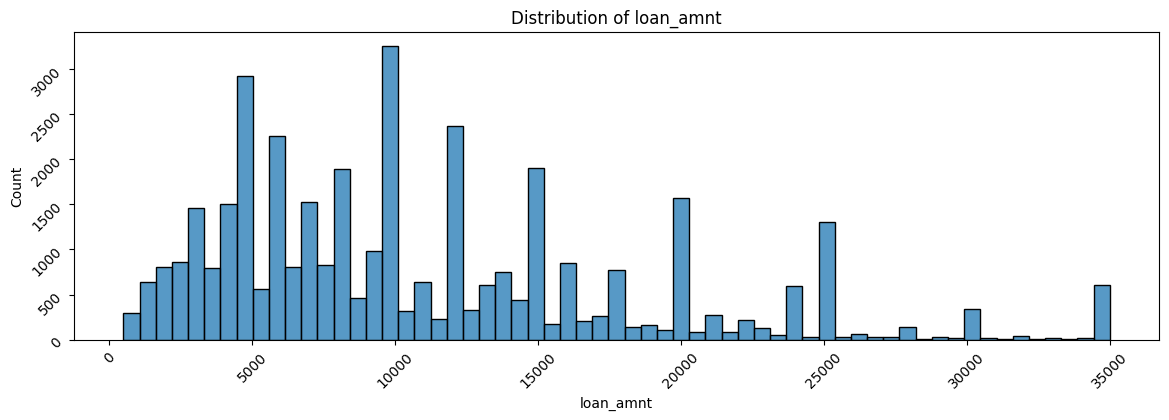

count  for columns funded_amnt
################ Quantiles ################
count   37880.000
mean    10801.616
std      7103.048
min       500.000
5%       2400.000
25%      5200.000
50%      9600.000
75%     15000.000
95%     25000.000
max     35000.000
Name: funded_amnt, dtype: float64


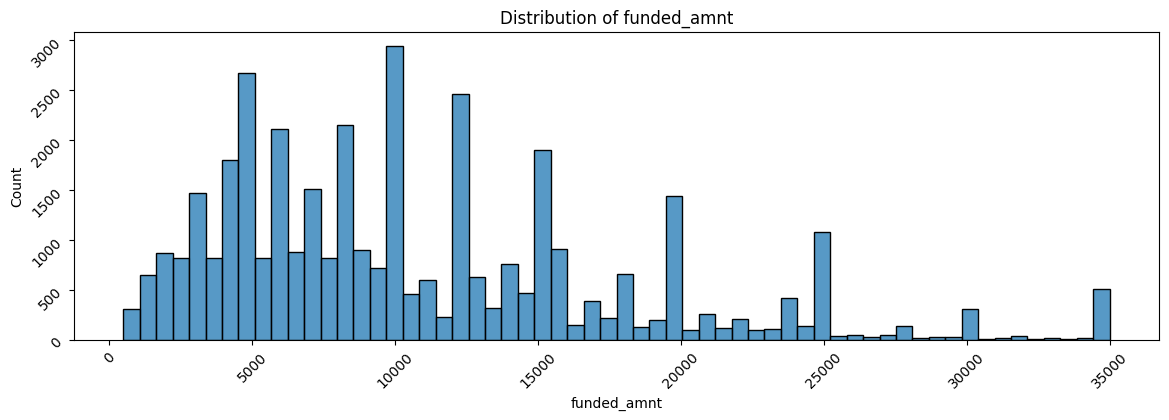

count  for columns funded_amnt_inv
################ Quantiles ################
count   37880.000
mean    10367.231
std      6999.223
min         0.000
5%       2000.000
25%      5000.000
50%      8974.846
75%     14200.000
95%     24575.000
max     35000.000
Name: funded_amnt_inv, dtype: float64


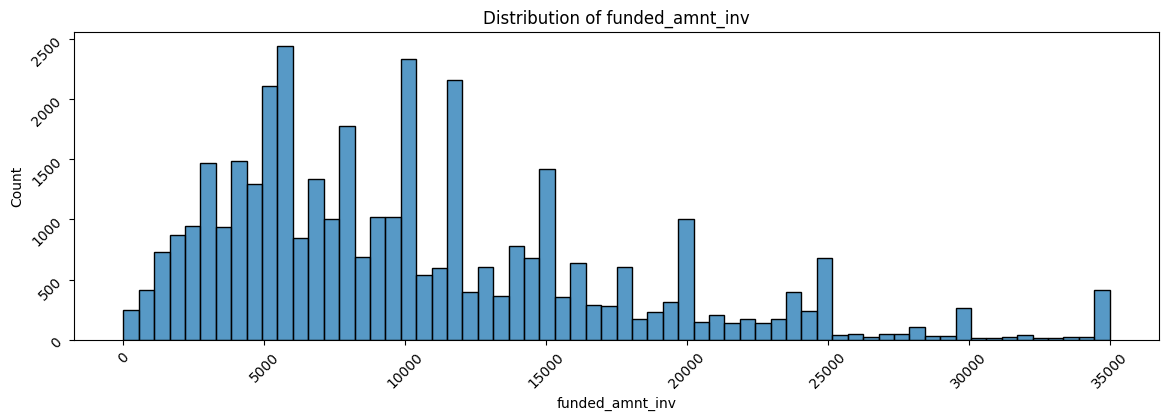

count  for columns term
################ Quantiles ################
count   37880.000
mean       42.007
std        10.396
min        36.000
5%         36.000
25%        36.000
50%        36.000
75%        60.000
95%        60.000
max        60.000
Name: term, dtype: float64


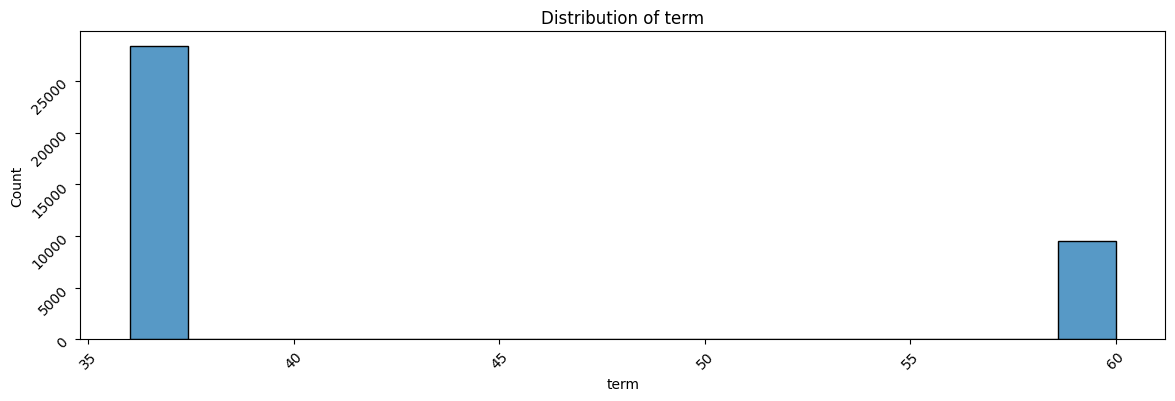

count  for columns int_rate
################ Quantiles ################
count   37880.000
mean       11.956
std         3.710
min         5.420
5%          6.170
25%         8.940
50%        11.830
75%        14.460
95%        18.390
max        24.400
Name: int_rate, dtype: float64


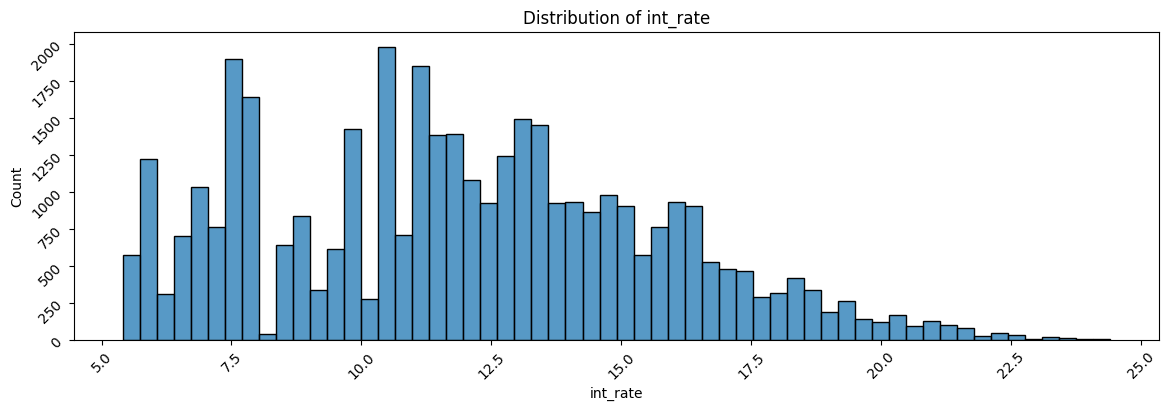

count  for columns installment
################ Quantiles ################
count   37880.000
mean      322.469
std       208.620
min        16.080
5%         70.769
25%       165.820
50%       277.760
75%       425.550
95%       759.879
max      1305.190
Name: installment, dtype: float64


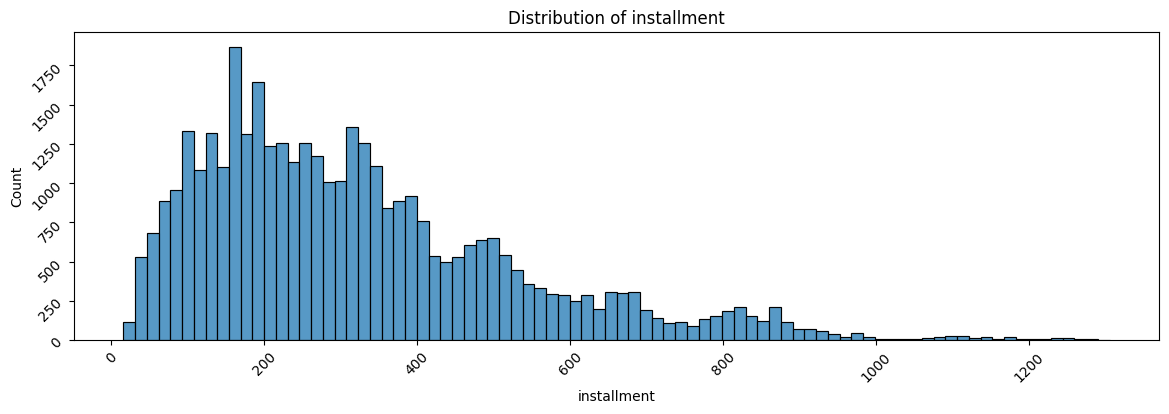

count  for columns annual_inc
################ Quantiles ################
count     37880.000
mean      68763.870
std       63573.786
min        4000.000
5%        24000.000
25%       40000.000
50%       59000.000
75%       82000.000
95%      140004.000
max     6000000.000
Name: annual_inc, dtype: float64


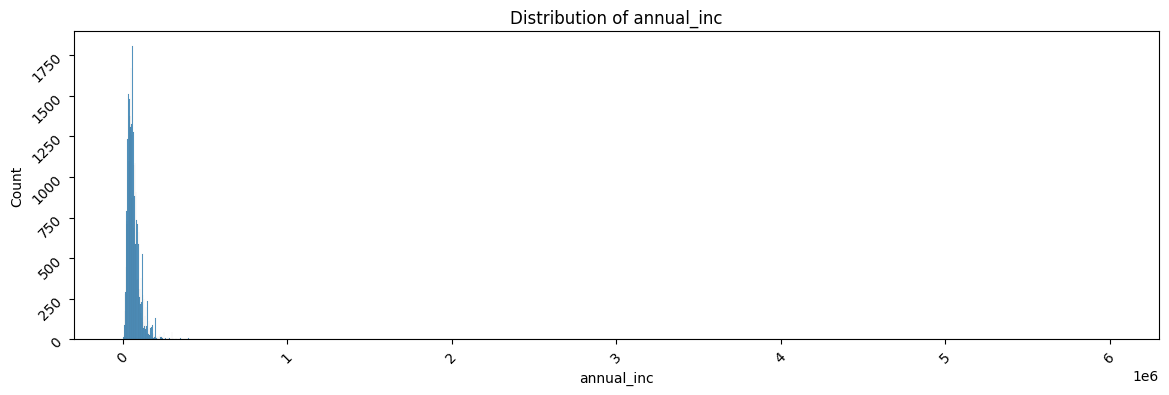

count  for columns dti
################ Quantiles ################
count   37880.000
mean       13.318
std         6.665
min         0.000
5%          2.150
25%         8.190
50%        13.410
75%        18.590
95%        23.810
max        29.990
Name: dti, dtype: float64


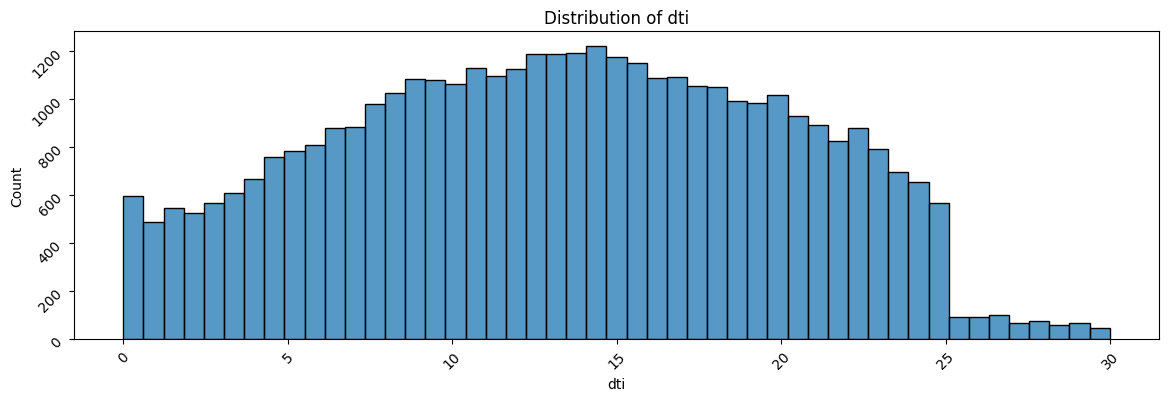

count  for columns delinq_2yrs
################ Quantiles ################
count   37880.000
mean        0.146
std         0.491
min         0.000
5%          0.000
25%         0.000
50%         0.000
75%         0.000
95%         1.000
max        11.000
Name: delinq_2yrs, dtype: float64


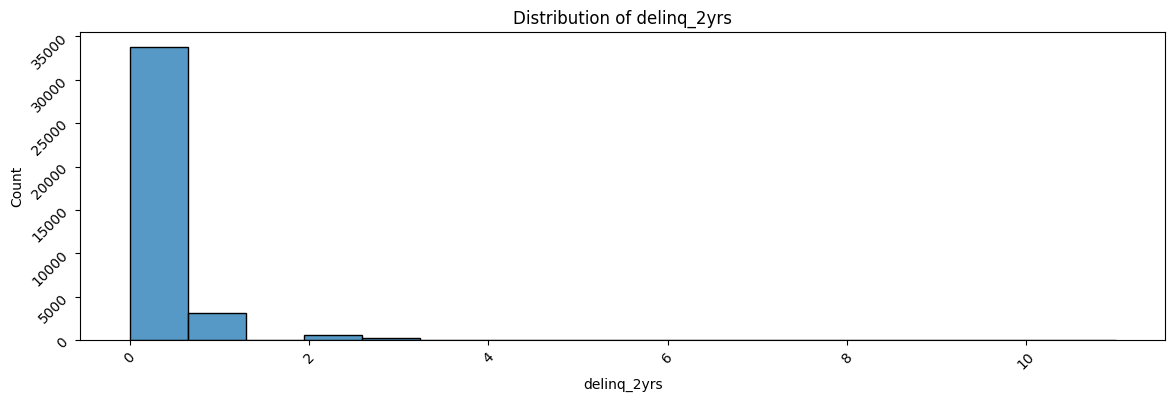

count  for columns inq_last_6mths
################ Quantiles ################
count   37880.000
mean        0.869
std         1.068
min         0.000
5%          0.000
25%         0.000
50%         1.000
75%         1.000
95%         3.000
max         8.000
Name: inq_last_6mths, dtype: float64


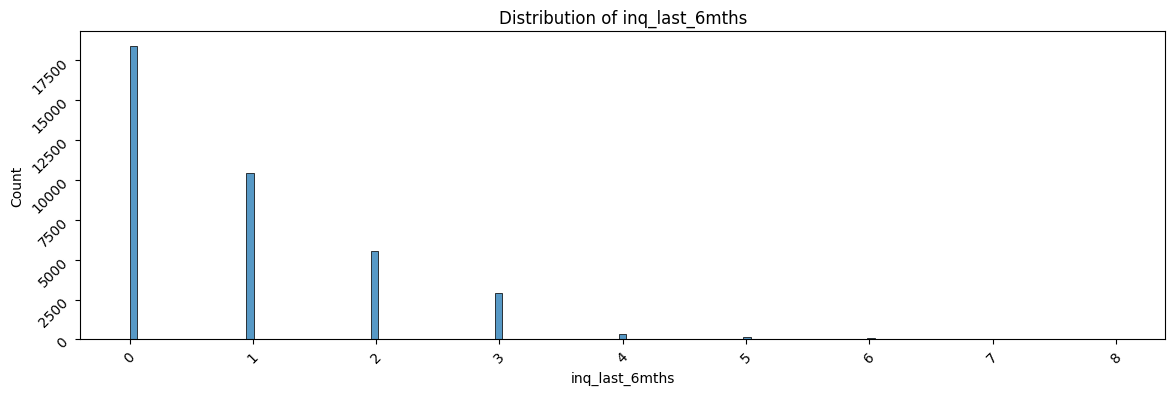

count  for columns open_acc
################ Quantiles ################
count   37880.000
mean        9.273
std         4.383
min         2.000
5%          3.000
25%         6.000
50%         9.000
75%        12.000
95%        17.000
max        44.000
Name: open_acc, dtype: float64


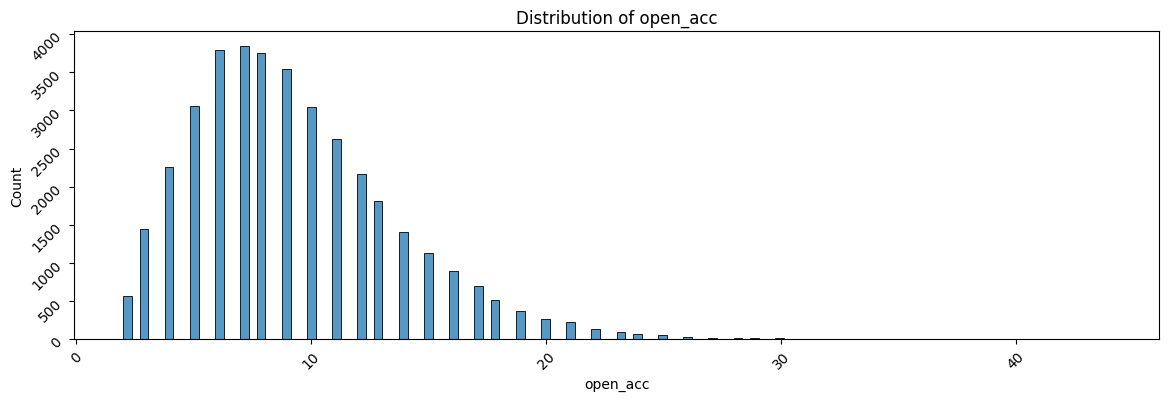

count  for columns pub_rec
################ Quantiles ################
count   37880.000
mean        0.056
std         0.239
min         0.000
5%          0.000
25%         0.000
50%         0.000
75%         0.000
95%         1.000
max         4.000
Name: pub_rec, dtype: float64


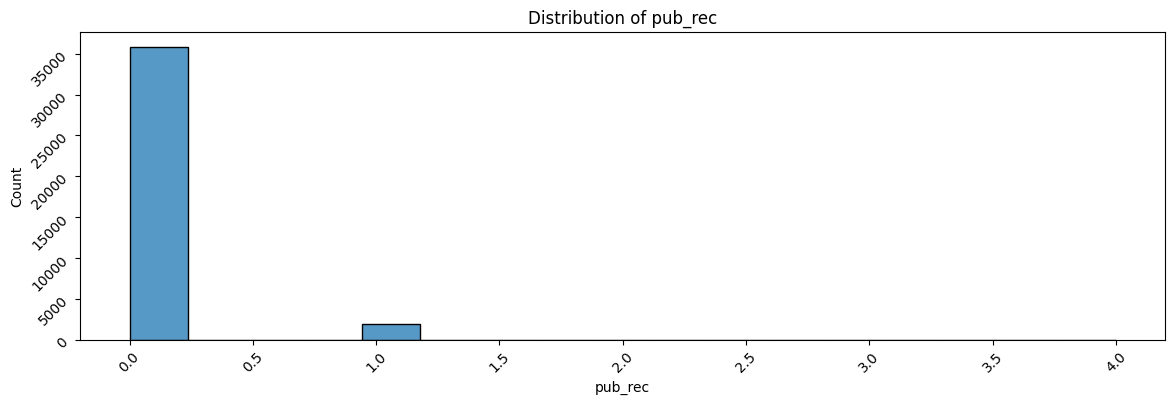

count  for columns pub_rec_bankruptcies
################ Quantiles ################
count   37880.000
mean        0.043
std         0.205
min         0.000
5%          0.000
25%         0.000
50%         0.000
75%         0.000
95%         0.000
max         2.000
Name: pub_rec_bankruptcies, dtype: float64


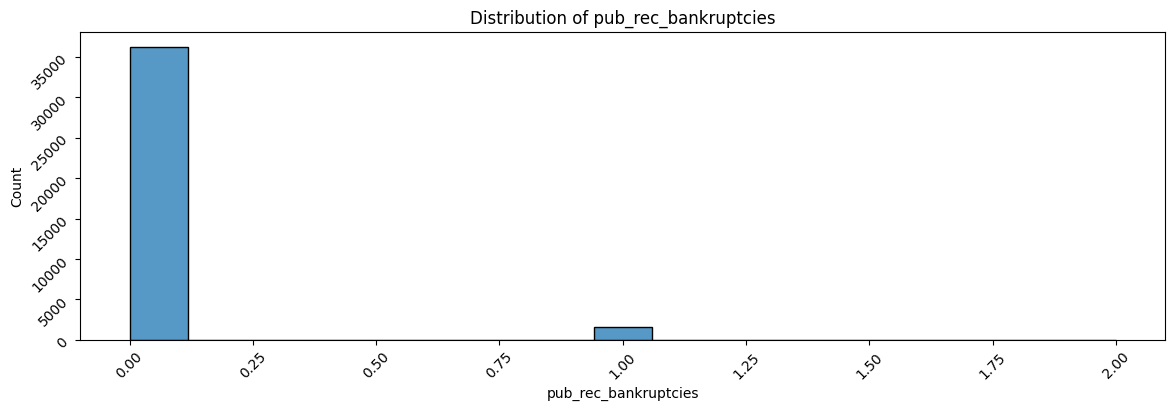

count  for columns issue_y
################ Quantiles ################
count   37880.000
mean     2010.358
std         0.811
min      2007.000
5%       2009.000
25%      2010.000
50%      2011.000
75%      2011.000
95%      2011.000
max      2011.000
Name: issue_y, dtype: float64


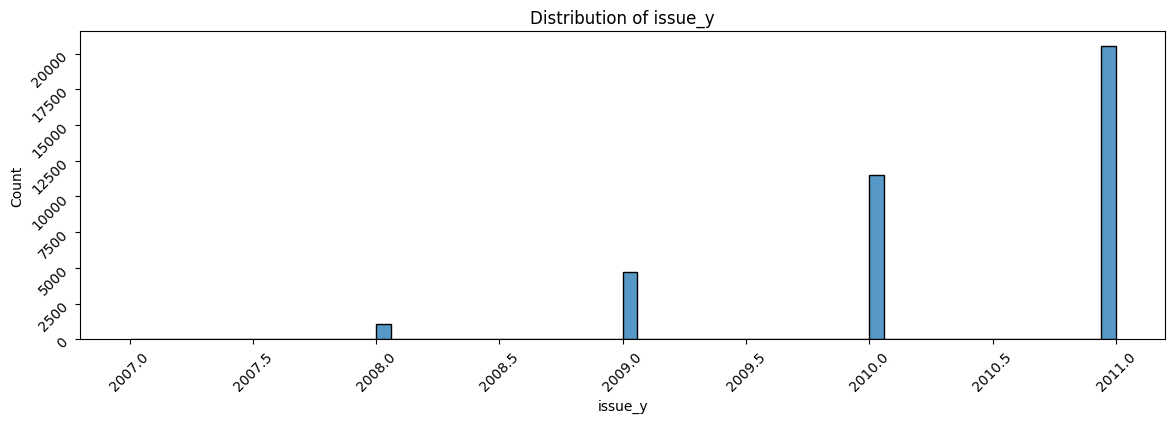

count  for columns issue_m
################ Quantiles ################
count   37880.000
mean        7.157
std         3.380
min         1.000
5%          1.000
25%         4.000
50%         7.000
75%        10.000
95%        12.000
max        12.000
Name: issue_m, dtype: float64


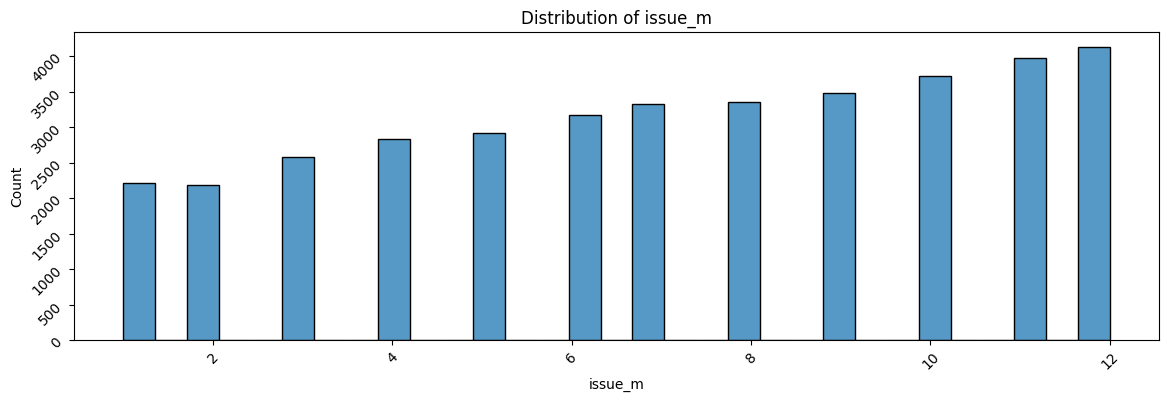

count  for columns annual_inc_mn
################ Quantiles ################
count   37880.000
mean        0.069
std         0.064
min         0.004
5%          0.024
25%         0.040
50%         0.059
75%         0.082
95%         0.140
max         6.000
Name: annual_inc_mn, dtype: float64


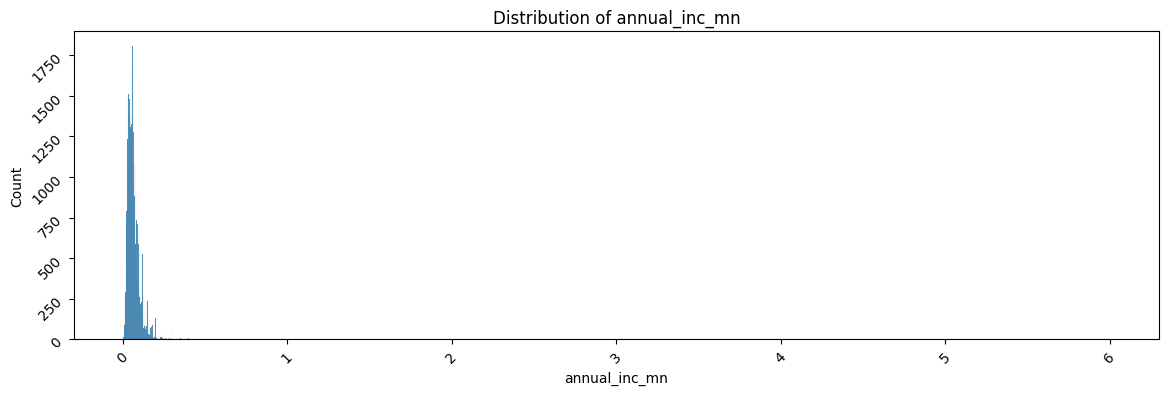

In [20]:




def plot_numerical_distributions(df, column1):
    '''
    Plot histograms for univariate analysis.

    Params:
      dframe: Dataframe to read
      column1: Qunatitative columns in dataset
    '''
    print('################ Quantiles ################')
    print(df[column1].describe([0.05,0.25,0.50,0.75,0.95]))
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, figsize=(14, 4))

    # Plot the first countplot
    sns.histplot(data=df, x=column1, palette='Set1')
    axes.set_title(f'Distribution of {column1}')
    axes.set_xlabel(column1)
    axes.set_ylabel('Count')
    axes.tick_params(rotation=45)
   # Show the plots
    plt.show()



for i in num_cols:
    print(f'count  for columns',i)
    plot_numerical_distributions(loan_paid_or_default,i)


 #### Interpretations from the above histograms


  - The visuals display the min and max values for each variable as well as  places where the majority of similar values fall.

  - The variables contain a few extreme values that contribute to the outliers. 

  - The majority of borrower **installments** have a value of less than 400.

  - **funded_amnt_inv** - The majority of applicants are granted loan between 4,500 and 10,000.

  - **dti** ratio varies extensively between 0 to 25. Lender tend to take risks by giving loans to clients with higher debt to income levels.

  - Most of the borrowers ask for a **loan_amount** of 5000 or 10000 approximately

  - Usually, **int_rate** is offered in the range of 6-8% or 10-15%. May be the case that the interest rate is higher for the borrowers with higher debt-to-income ratios. Perhaps the interest rate fluctuates periodically depending on the purpose of loan.

 -   No of Bankrupaticies are very less in the lending loan applicants 

 -   Most of the loan are given in he year 2011. This lending loan count is increasing from 2007 to 2011 

 -   Most of the loans are issues in the month of  November, December

 -   Most of the loan applicants are in *installment* type of 36 months



### Update the annual_inc column in multiple bins 

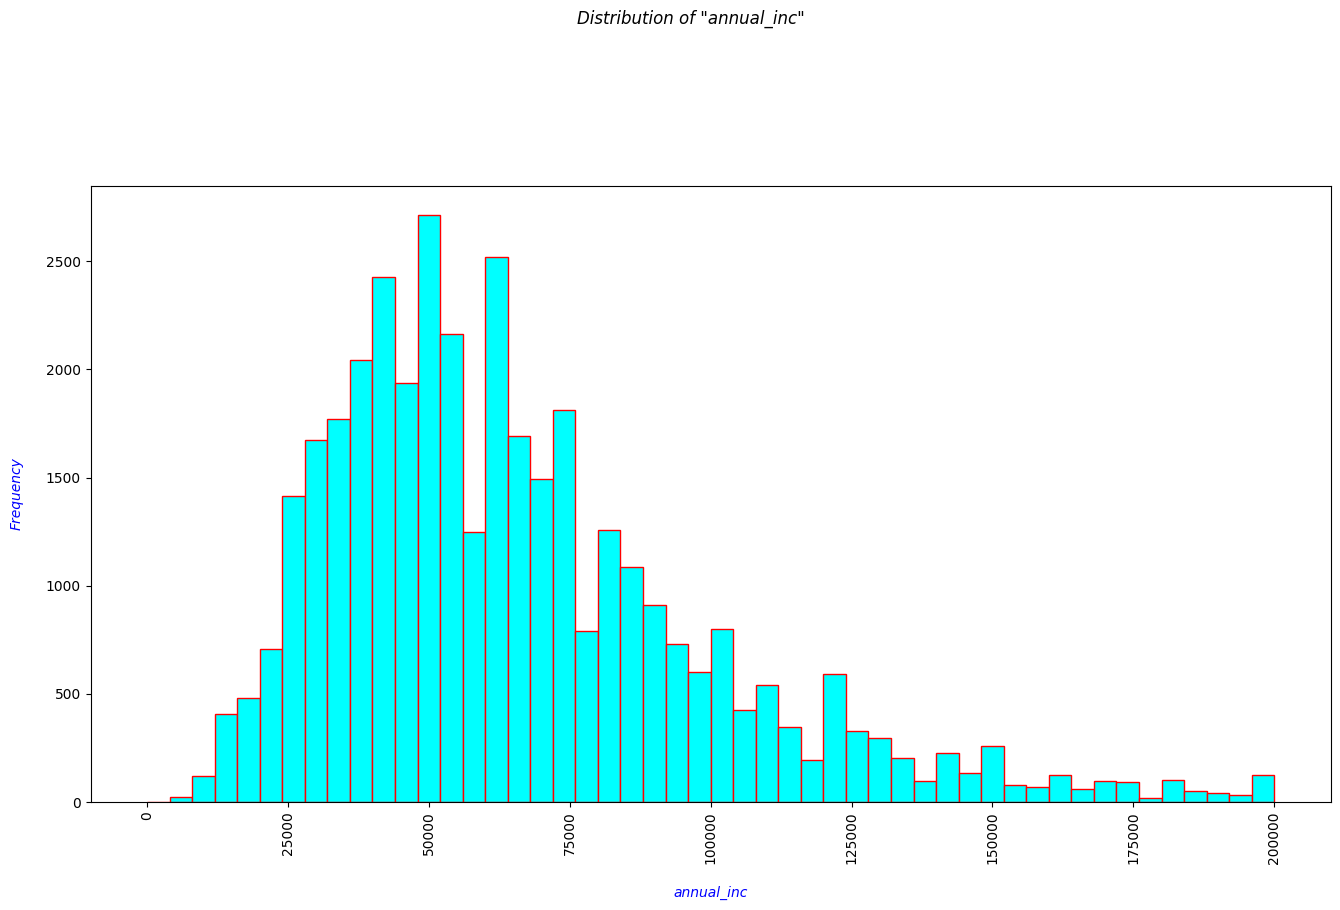

In [21]:
fig = plt.figure()
fig.set_size_inches(16, 8)
ax = plt.subplot(111)
num, bins, _ = ax.hist(loan_paid_or_default.annual_inc, bins=50, range=(0, 200000), color='cyan', edgecolor='red')
plt.xticks(rotation=90)
ax.set_xlabel('\nannual_inc', fontdict=dict(fontsize=10, fontweight=20, color='blue', fontstyle='oblique'))
ax.set_ylabel('Frequency\n', fontdict=dict(fontsize=10, fontweight=20, color='blue', fontstyle='oblique'))
fig.suptitle('Distribution of "annual_inc"\n', color='black', fontstyle='oblique', y=1.1)
plt.show()


### Interprtations from above histogram 

  -  Most of the applicants are from 25000 to 75000 income range. This mean  lender get most of the requests from less salaries individuals


### Treate the Outlier in **annual_inc** column 

In [22]:
quantile_values = np.percentile(loan_paid_or_default["annual_inc"].dropna(), range(0, 101))
lower_bound = quantile_values[5]
upper_bound = quantile_values[95]
filter_cond_commit = (loan_paid_or_default["annual_inc"] < lower_bound) | (loan_paid_or_default["annual_inc"] > upper_bound)
loan_paid_or_default["annual_inc"][filter_cond_commit] = np.nan



#### **Univariate Analysis on Categorical Variables** 

In [23]:
cat_cols = loan_paid_or_default.select_dtypes(['object','bool'])

In [24]:



def plot_categorical_distributions(df, column1):
     '''
    Count Plot for univariate analysis on Categorical Variables.

    Params:
      dframe: Dataframe to read
      column1: Qunatitative columns in dataset
    '''
    # Create a figure with two subplots side by side
     
     fig, axes= plt.subplots(1, figsize=(16,6))

    # Plot the first countplot
     sns.countplot(data=df, x=column1, palette='Set1')
     axes.set_title(f'Distribution of {column1}')
     axes.set_xlabel(column1)
     axes.set_ylabel('Count')
     axes.tick_params(rotation=45)
     freq = df[column1].value_counts()
     for i in zip(freq.index, freq):
         axes.annotate(xy=i, text=f'{round(i[1]/freq.sum()*100, 1)}%', horizontalalignment='left', verticalalignment='bottom')
   # Show the plots
     plt.show()









count  for columns grade


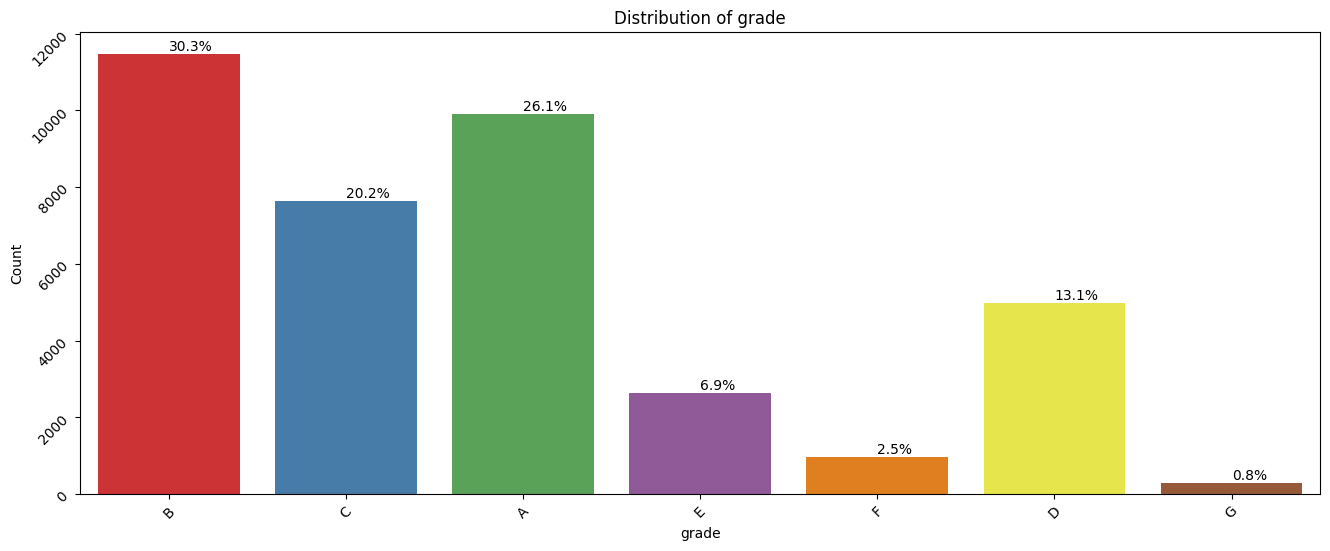

count  for columns sub_grade


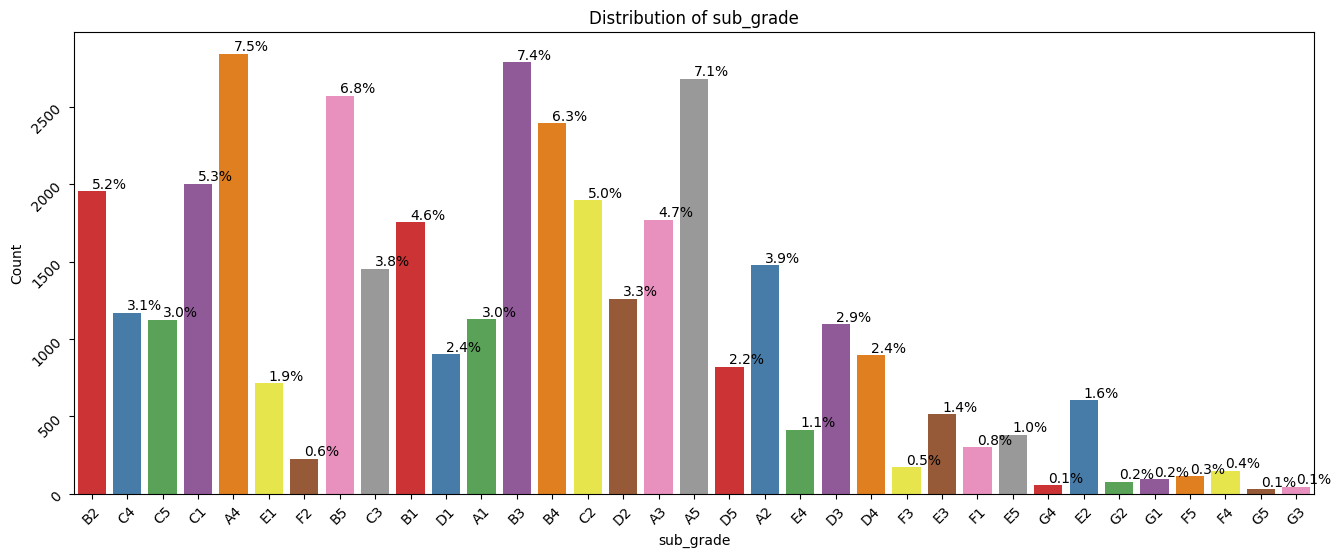

count  for columns emp_length


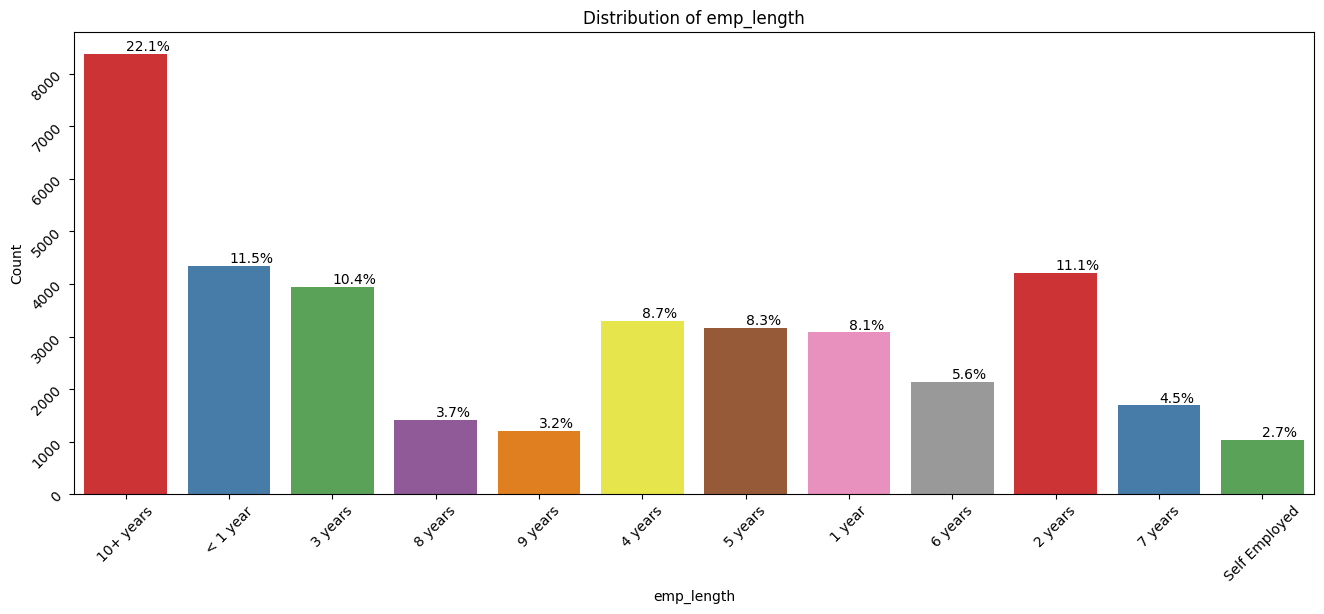

count  for columns home_ownership


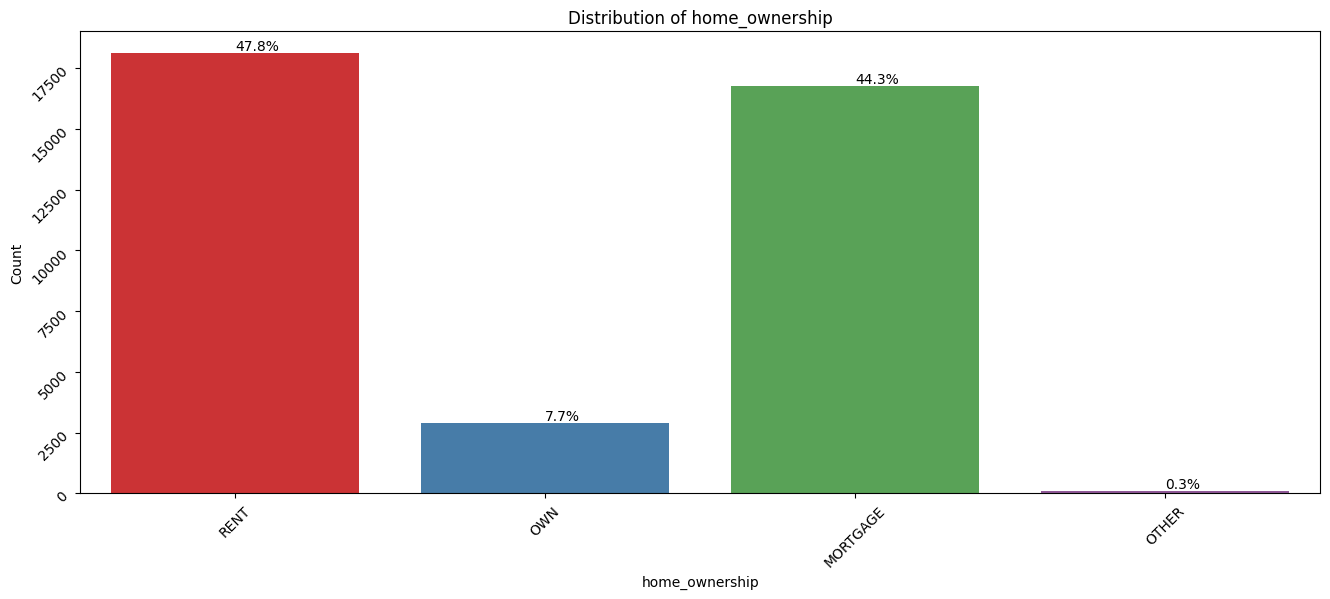

count  for columns verification_status


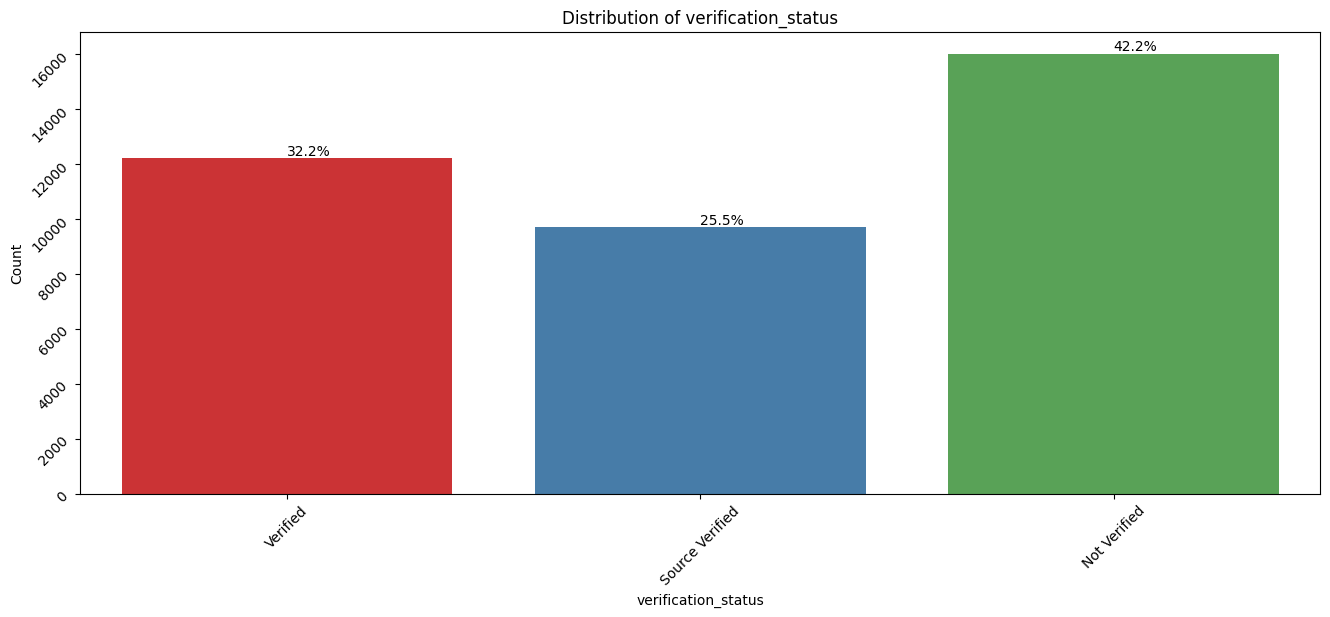

count  for columns loan_status


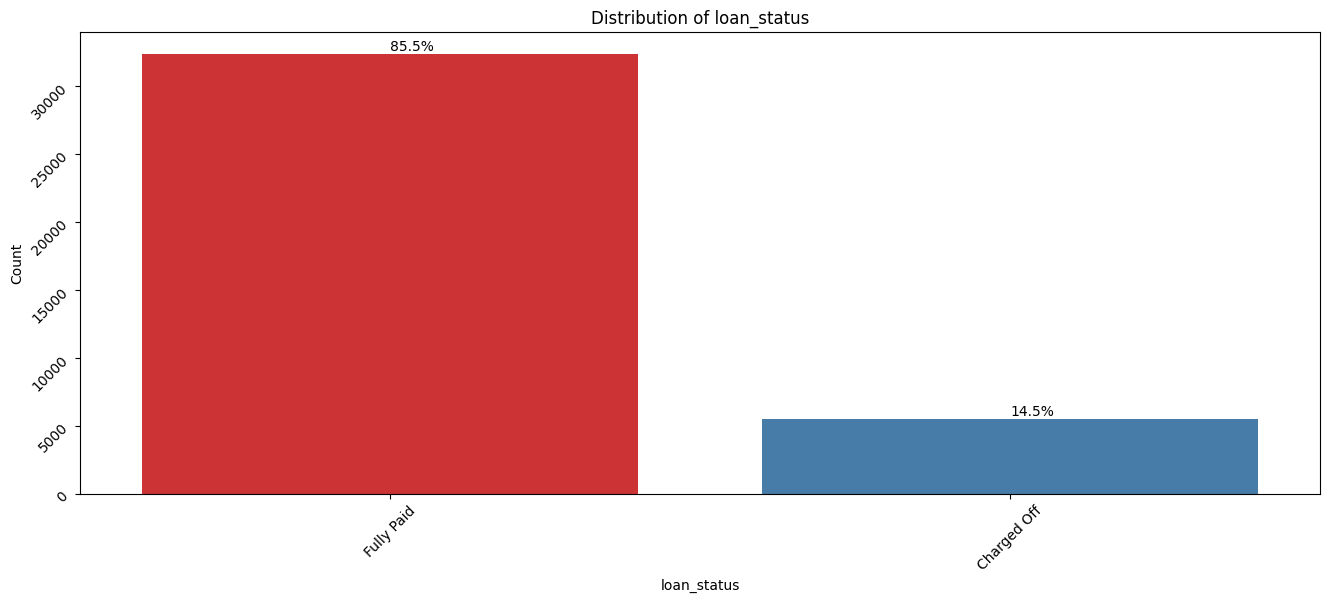

count  for columns purpose


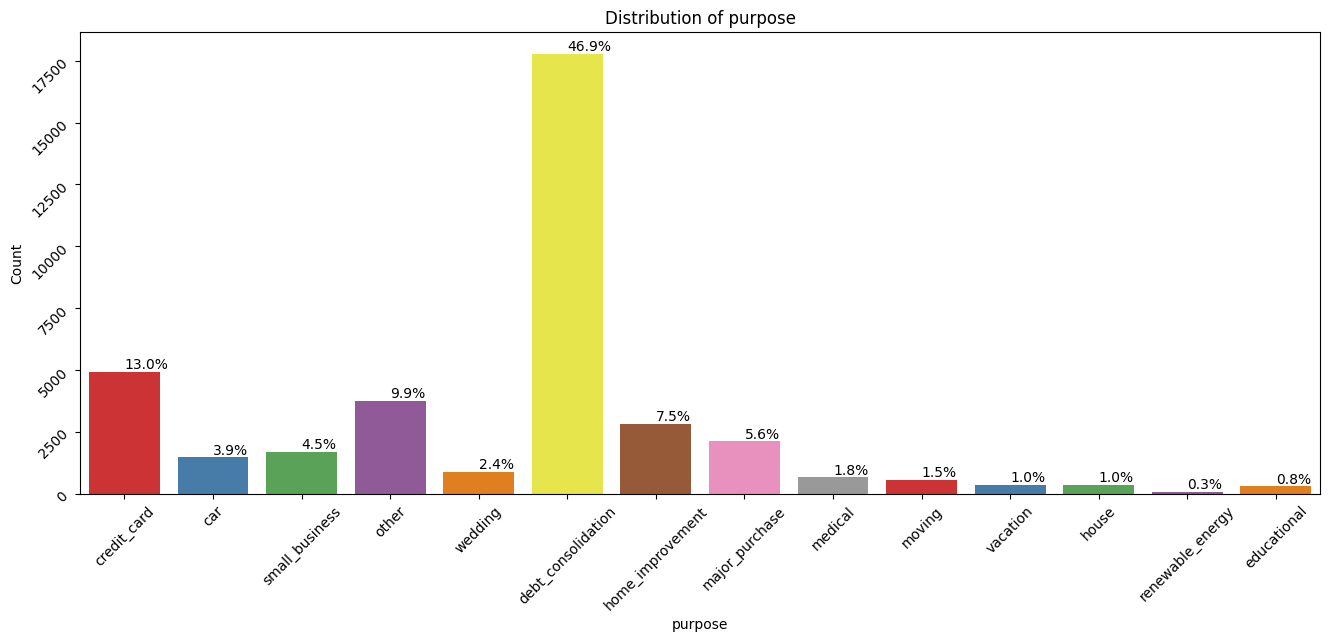

count  for columns addr_state


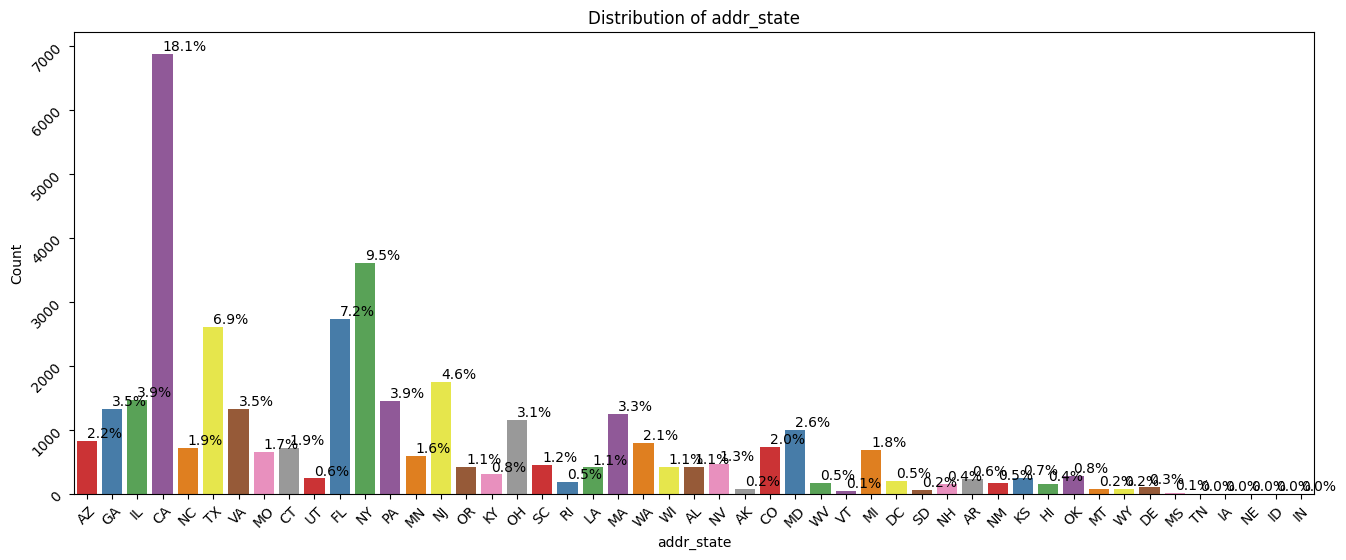

In [25]:
for i in cat_cols:
    print(f'count  for columns',i)
    plot_categorical_distributions(loan_paid_or_default,i)

__Interpretation from the above Categorical  plots__



   -  Most of applicants are from **A** and **B** grade levels

   -  These   are  the top 4 subgrades of **A4**, **A5** and **B3** and **B4**

   -  Employees with **10+ years** experience are taking more loand and Employess less than or equals to  **3 years** follows next

   -  Applicants on **RENT** and **Mortgage** are taking more loans

   -  Applicatns with **Verfied** status are taking more loans 

   -  Most of the people are taking loas for **Debt Cosolidation**

   -  Most of the applicants are from these address states --  **CA**, **NY** and **FL** 



#### **Segmented Univariate Analysis to assess the influence of Numerical Variables on Loan Statuses**

In [46]:
def plot_numerical_bivariate(df,column1,column2=loan_paid_or_default["loan_status"]):

   
    
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(figsize=(14,4))

    # Plot the first countplot
    sns.boxplot(data=df, x=column1,y=column2, palette='Set1')
    axes.set_title(f'Variation of {column1} with loan_status')
    axes.tick_params(rotation=45)
   # Show the plots
    plt.show()
    






                count      mean      std      min      25%       50%  \
loan_status                                                            
Charged Off  5509.000 12093.983 8101.800 1000.000 5600.000 10000.000   
Fully Paid  32371.000 10892.333 7216.565  500.000 5200.000  9600.000   

                  75%       max  
loan_status                      
Charged Off 16450.000 35000.000  
Fully Paid  15000.000 35000.000  



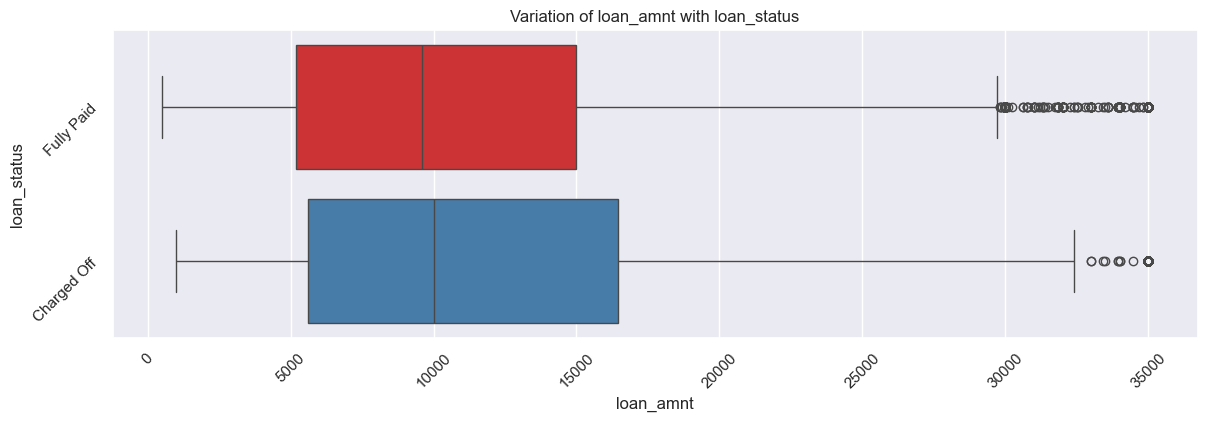


                count      mean      std      min      25%       50%  \
loan_status                                                            
Charged Off  5509.000 11740.053 7768.560 1000.000 5550.000 10000.000   
Fully Paid  32371.000 10641.909 6971.038  500.000 5100.000  9250.000   

                  75%       max  
loan_status                      
Charged Off 16000.000 35000.000  
Fully Paid  14575.000 35000.000  



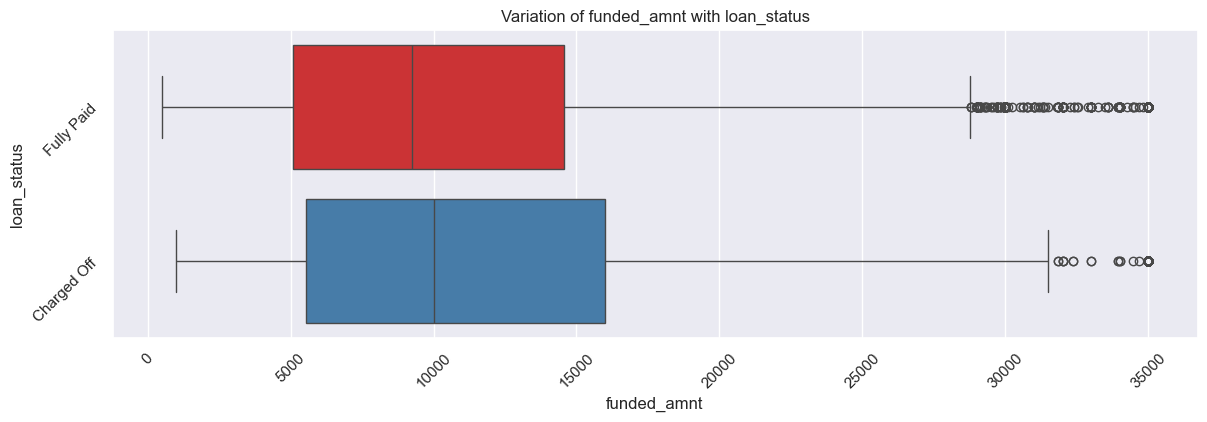


                count      mean      std   min      25%      50%       75%  \
loan_status                                                                  
Charged Off  5509.000 11056.941 7624.606 0.000 5000.000 9600.000 15000.000   
Fully Paid  32371.000 10249.854 6880.387 0.000 5000.000 8850.000 14000.000   

                  max  
loan_status            
Charged Off 35000.000  
Fully Paid  35000.000  



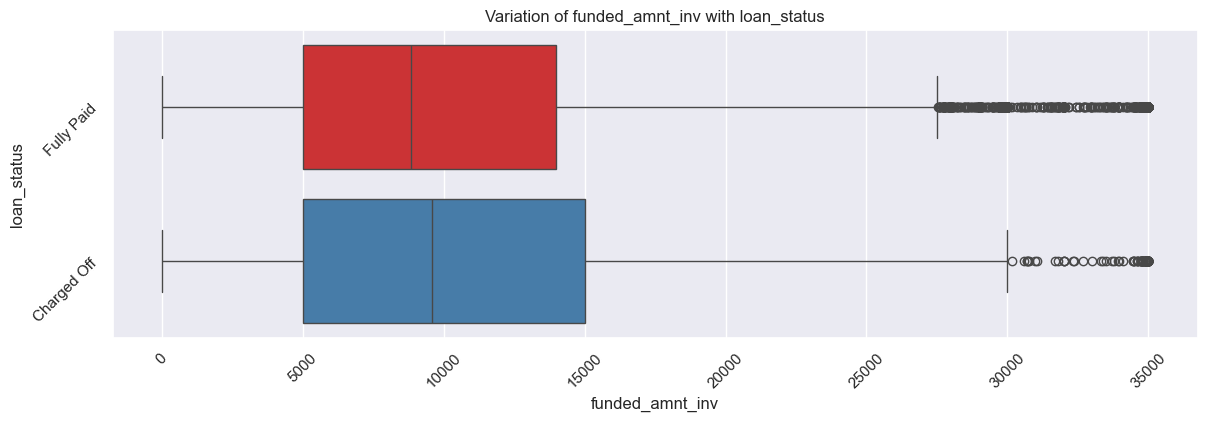


                count   mean    std    min    25%    50%    75%    max
loan_status                                                           
Charged Off  5509.000 46.456 11.901 36.000 36.000 36.000 60.000 60.000
Fully Paid  32371.000 41.250  9.922 36.000 36.000 36.000 36.000 60.000



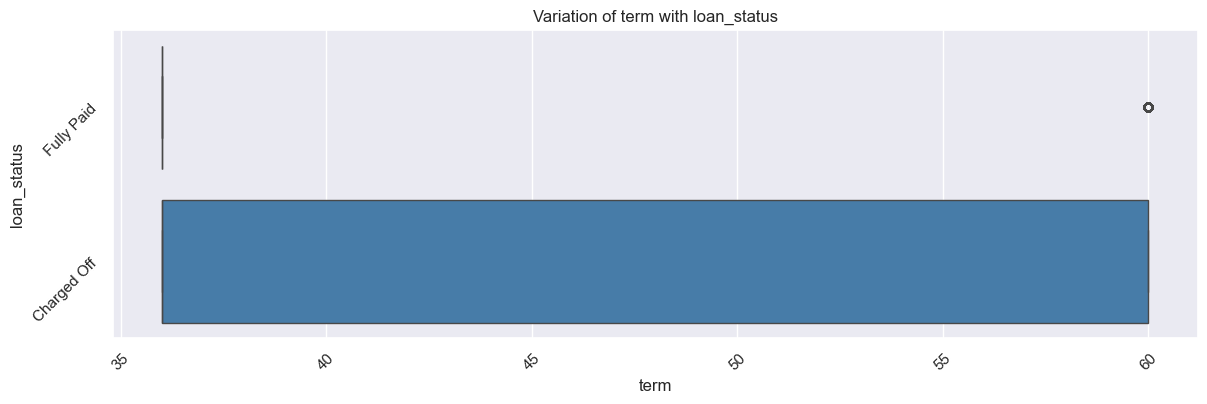


                count   mean   std   min    25%    50%    75%    max
loan_status                                                         
Charged Off  5509.000 13.867 3.668 5.420 11.360 13.720 16.450 24.400
Fully Paid  32371.000 11.631 3.618 5.420  8.490 11.490 13.990 24.110



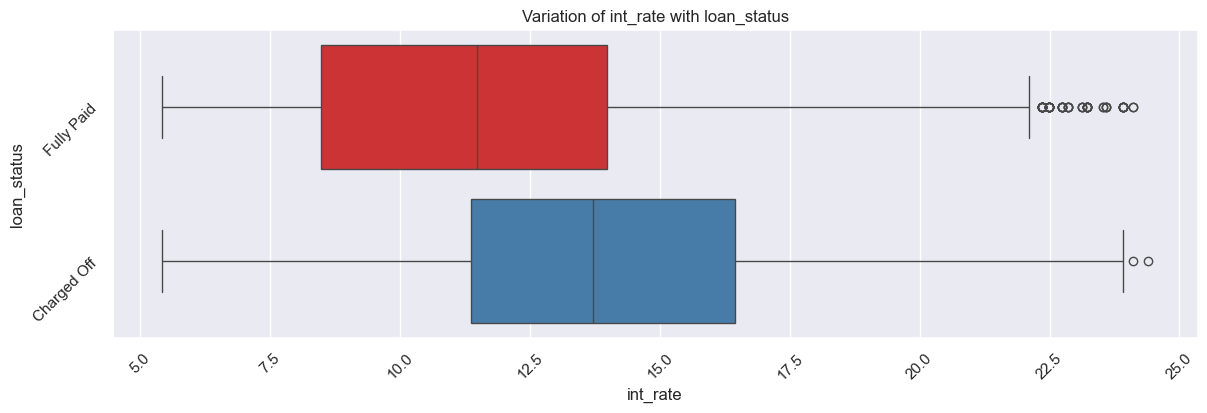


                count    mean     std    min     25%     50%     75%      max
loan_status                                                                  
Charged Off  5509.000 334.578 216.090 22.790 168.470 291.760 454.180 1305.190
Fully Paid  32371.000 320.409 207.255 16.080 165.380 275.760 421.590 1295.210



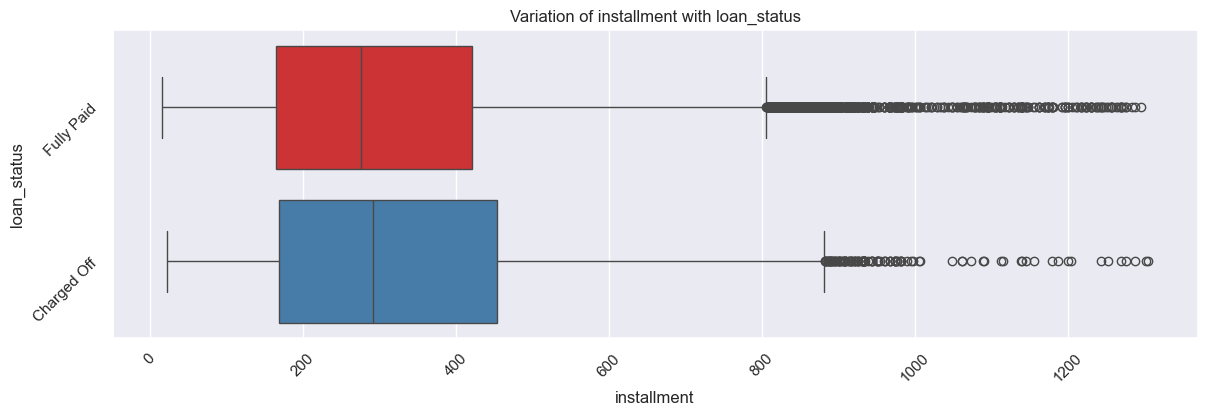


                count      mean       std       min       25%       50%  \
loan_status                                                               
Charged Off  4958.000 59084.017 25259.173 24000.000 40000.000 54000.000   
Fully Paid  29306.000 63775.318 26788.445 24000.000 42516.000 60000.000   

                  75%        max  
loan_status                       
Charged Off 73000.000 140004.000  
Fully Paid  80000.000 140004.000  



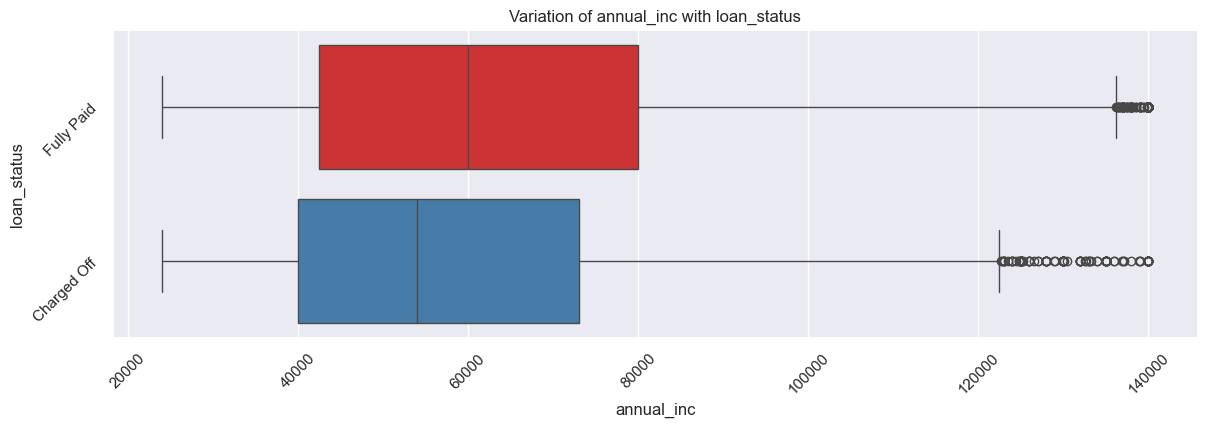


                count   mean   std   min   25%    50%    75%    max
loan_status                                                        
Charged Off  5509.000 14.042 6.574 0.000 9.130 14.330 19.320 29.850
Fully Paid  32371.000 13.194 6.672 0.000 8.030 13.240 18.450 29.990



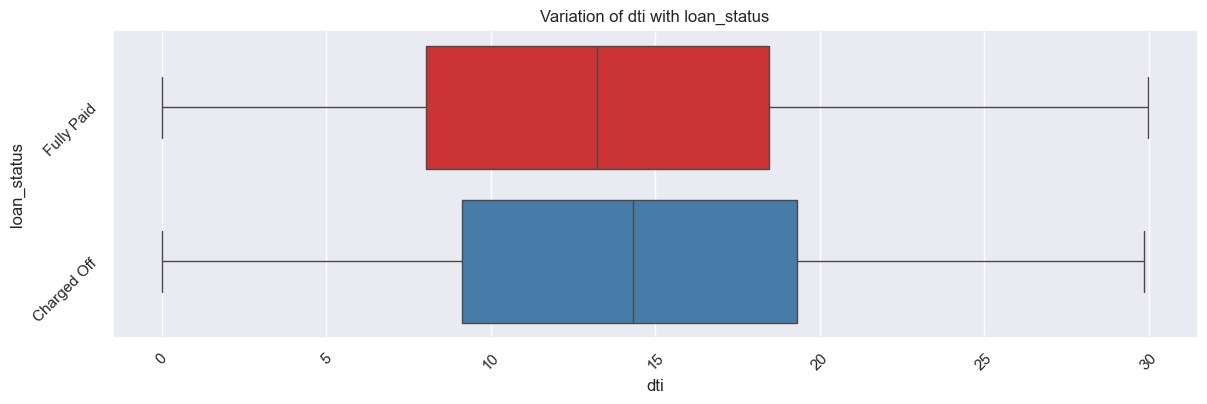


                count  mean   std   min   25%   50%   75%    max
loan_status                                                     
Charged Off  5509.000 0.168 0.531 0.000 0.000 0.000 0.000  8.000
Fully Paid  32371.000 0.142 0.484 0.000 0.000 0.000 0.000 11.000



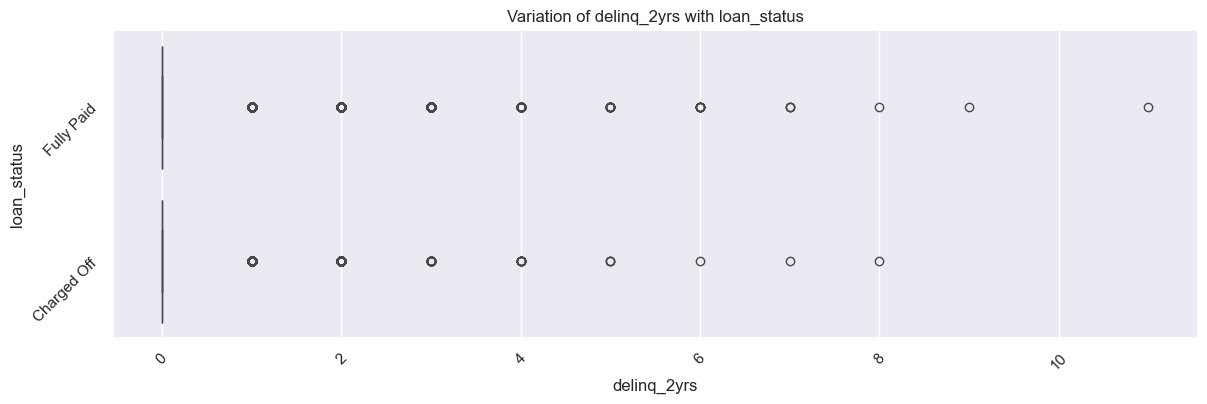


                count  mean   std   min   25%   50%   75%   max
loan_status                                                    
Charged Off  5509.000 1.052 1.149 0.000 0.000 1.000 2.000 8.000
Fully Paid  32371.000 0.838 1.051 0.000 0.000 1.000 1.000 8.000



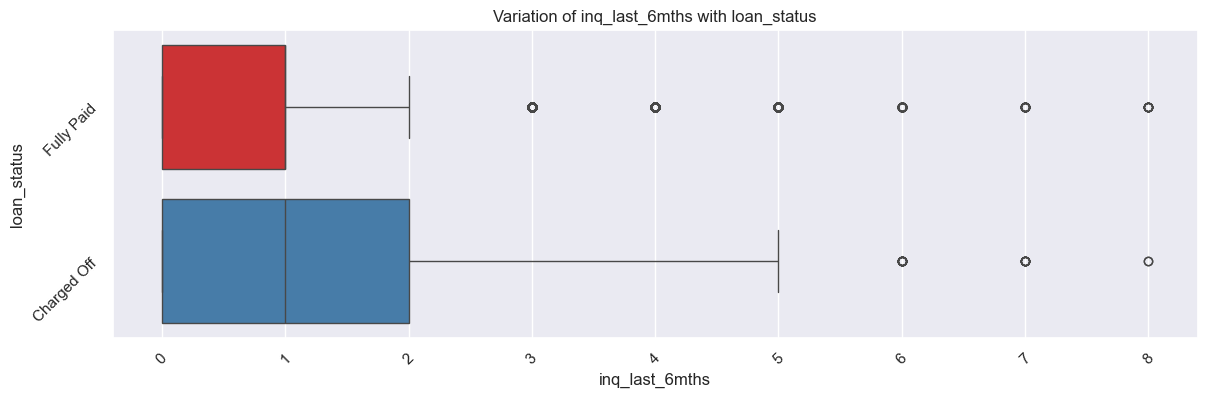


                count  mean   std   min   25%   50%    75%    max
loan_status                                                      
Charged Off  5509.000 9.173 4.502 2.000 6.000 8.000 12.000 38.000
Fully Paid  32371.000 9.290 4.363 2.000 6.000 9.000 12.000 44.000



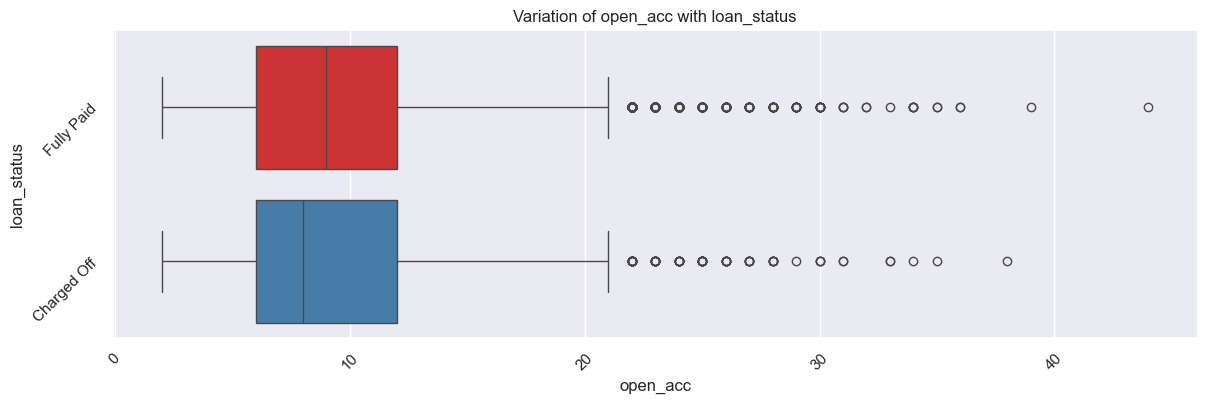


                count  mean   std   min   25%   50%   75%   max
loan_status                                                    
Charged Off  5509.000 0.085 0.286 0.000 0.000 0.000 0.000 2.000
Fully Paid  32371.000 0.051 0.229 0.000 0.000 0.000 0.000 4.000



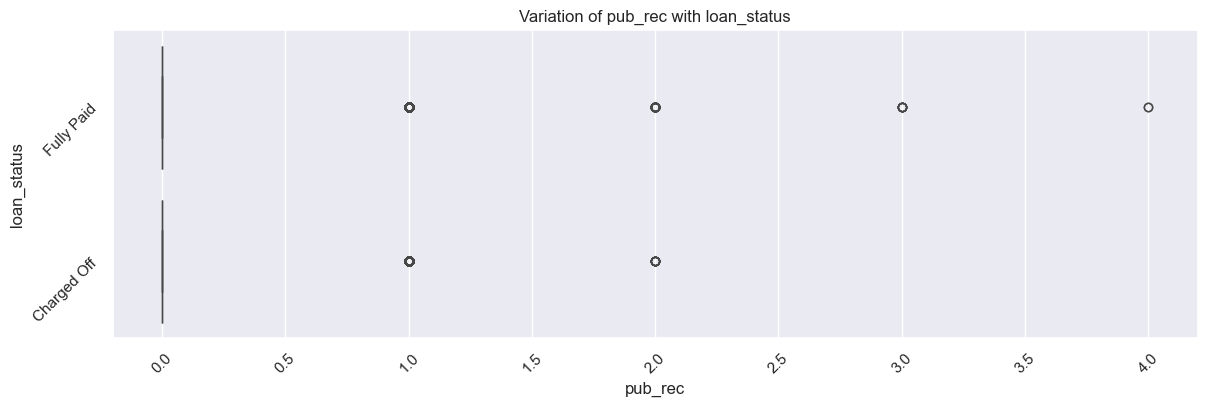


                count  mean   std   min   25%   50%   75%   max
loan_status                                                    
Charged Off  5509.000 0.067 0.252 0.000 0.000 0.000 0.000 2.000
Fully Paid  32371.000 0.039 0.195 0.000 0.000 0.000 0.000 2.000



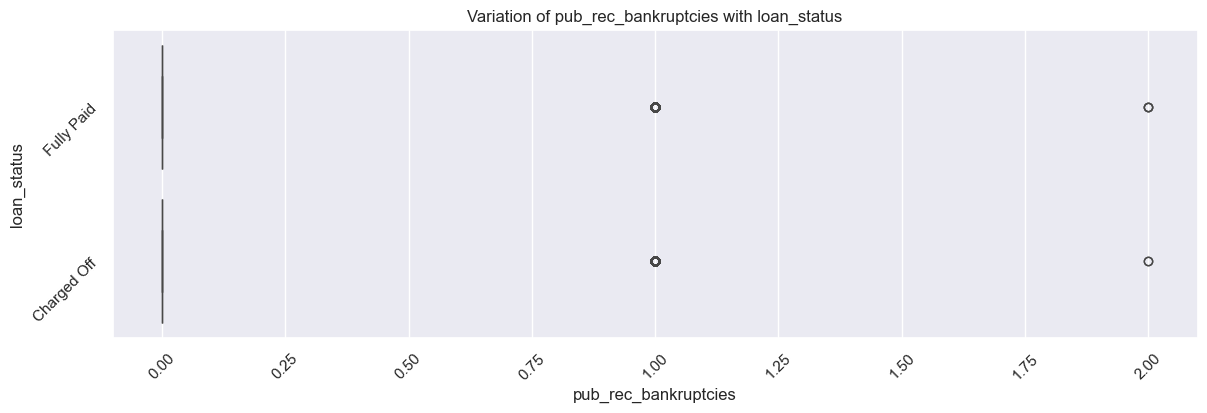


                count     mean   std      min      25%      50%      75%  \
loan_status                                                                
Charged Off  5509.000 2010.419 0.807 2007.000 2010.000 2011.000 2011.000   
Fully Paid  32371.000 2010.347 0.811 2007.000 2010.000 2011.000 2011.000   

                 max  
loan_status           
Charged Off 2011.000  
Fully Paid  2011.000  



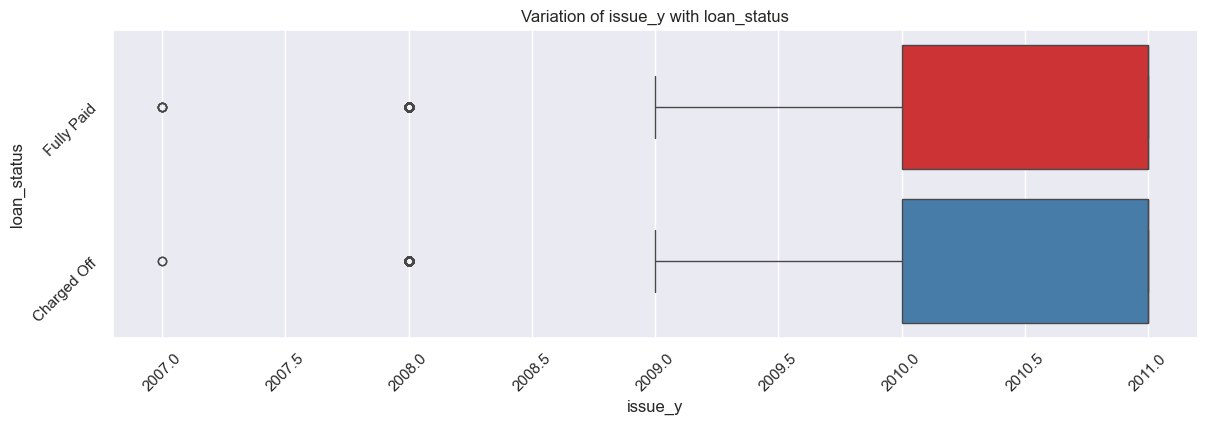


                count  mean   std   min   25%   50%    75%    max
loan_status                                                      
Charged Off  5509.000 7.366 3.330 1.000 5.000 8.000 10.000 12.000
Fully Paid  32371.000 7.122 3.387 1.000 4.000 7.000 10.000 12.000



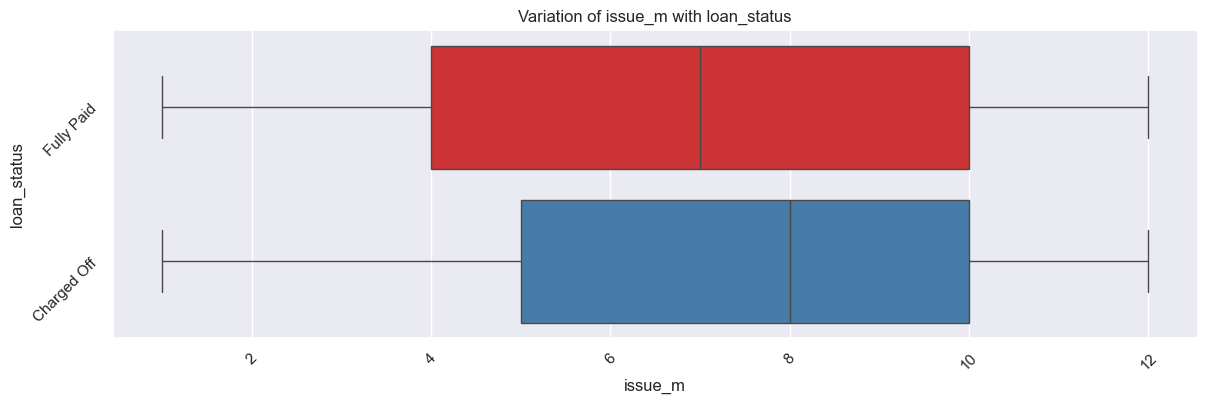


                count  mean   std   min   25%   50%   75%   max
loan_status                                                    
Charged Off  5509.000 0.062 0.047 0.004 0.037 0.053 0.075 1.250
Fully Paid  32371.000 0.070 0.066 0.004 0.042 0.060 0.084 6.000



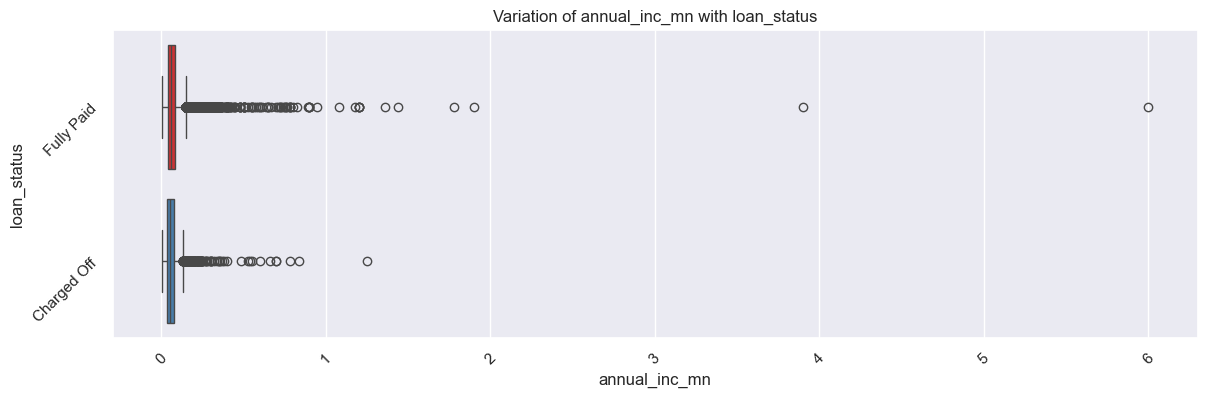

In [47]:
 #num_cols.drop(['issue_y','issue_m'],inplace=True,axis=1)
for i in num_cols:
    print("=================================================\n")
    print(loan_paid_or_default.groupby('loan_status')[i].describe())
    print("=================================================\n")
    plot_numerical_bivariate(loan_paid_or_default,i)

- **Analysis**


  - The interest rates of fully paid loans and defaulted loans differ noticeably, with the defaulted loan interest rate being greater on average. 

  - ***int_rate*** is likely to influence the loan status of the borrower. Thus, it is a driving factor behind loan default

  - The dti average of the loan defaulters is not significantly different than that of the borrowers who have already paid in full.

  - The 75th percentile value of the ***funded amount*** from investors is higher in the defaulted loans compared to the loans which are already paid in full. But the same difference cannot be observed with median or 25th          percentile values across the loan statuses.This shows that large amount of loans are more likely to default...

  - The 75th percentile ***installment*** is higher in charged-off loan account. But there is no significant difference in the 25th percentile values across the loan statuses, indicating that loans with larger installments are more likely to default.

  - The annual income of loan defaulters at 75th percentile is lower than those who have fully paid back their loans. <br>But when we compare the 25th percentile incomes, they are different but not as significant as 75th percentile incomes. <br>This shows that the borrowers with higher income are less likely to default.




### **Segmented Univariate Analysis to assess the influence of Categorical Variables on Loan Statuses**

In [27]:
def plot_categorical_bivariate(dframe, index_col, col, W, H, width, bbox_H, bbox_W, 
                               annotate_flag:bool=True, rotate_annotation:int=0, size:int=10):
    '''
    Create bar plots for Bi Variate  analysis on categorical variables

    Params:
       dframe: A dataframe to read
       index_col: A variable name to access in the dataframe and used as an index to create a pivot table
       col: A variable name to access in the dataframe and used as a column to create a pivot table
       W: A number to set the width of the plot
       H: A number to set the height of the plot
       width: A number to set the width of the bars in the plot
       bbox_H: Height of the bbox to anchor
       bbox_W: Width of the bbox to anchor
       annotate_flag: Default to True, will add annotations to the plot
       rotate_annotation: Default to 0, will not rotate the annotations in the plot
       size: Default to 10, will set the size of annotations compared to the specified value
    '''
    if isinstance(dframe, pd.DataFrame):
        try:
            x = dframe.pivot_table(index=index_col, columns=col, aggfunc='size')
            fig = plt.figure()
            fig.set_size_inches(w=W, h=H)
            ax = plt.subplot(111)
            z = np.arange(0, dframe[col].nunique())
            offset = 0
            rand_colors = np.random.choice(['yellow', 'pink', 'cyan'],
                                        x.index.nunique(),
                                        replace=False)
            for idx, legend_labels in enumerate(x.index):
                ax.bar(x=z+offset, height=x.loc[legend_labels], align='center', edgecolor='red', color=rand_colors[idx], width=width)
                if annotate_flag:
                    for xy in zip(z+offset, x.loc[legend_labels], z):
                        ax.annotate(xy=xy[:-1], text=f'{round(xy[1]/x.iloc[:, xy[2]].sum(axis=0)*100, 1)}%',
                                    horizontalalignment='left', verticalalignment='bottom', 
                                    rotation=rotate_annotation, size=size, fontweight=20)
                offset += width
            ax.set_xticks(ticks=z+width, labels=x.columns, rotation=90, fontsize=10, fontweight=20)
            ax.set_xlabel(col, fontdict=dict(fontsize=10, fontweight=20, color='blue', fontstyle='oblique'))
            ax.set_ylabel('count  of  '+index_col, fontdict=dict(fontsize=10, fontweight=20, color='green', fontstyle='oblique'))
            ax.legend(labels=x.index, fontsize=8, bbox_to_anchor=(bbox_W, bbox_H))
            if annotate_flag:
                fig.suptitle(f'Variability of "{col}" in relation to "{index_col}"', size=13, color='blue', fontstyle='oblique', y=1.05)
                ax.set_title(f'[ percentage = (no. of Charged-Off or Fully-Paid loans) divided by total loans in each category of "{col}" ]\n',
                         fontdict=dict(fontsize=10, fontweight=20, color='black', fontstyle='normal'),
                         loc='center')
            else:
                fig.suptitle(f'Variability of "{col}" in relation to "{index_col}"', size=13, color='blue', fontstyle='oblique', y=1)
            plt.show()
        except Exception as e:
            raise e        
    else:
        raise TypeError('Argument "dframe" must be a DataFrame')

1) <span style='color:green'>**term**</span>

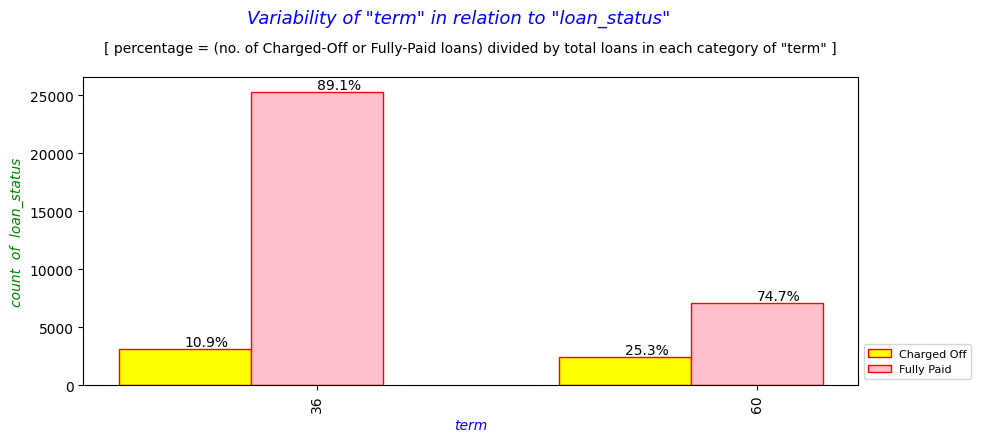

In [28]:
plot_categorical_bivariate(loan_paid_or_default, index_col='loan_status', col='term', 
                           W=10, H=4, width=.3, bbox_W=1.0, bbox_H=.15, annotate_flag=True)

- `Interpretation`

    - The percentage of defaulters in 60 months term  more than that of  36 months. So clearly term is influcenced variable for lending loans 

2) <span style='color:green'>**grade**</span>

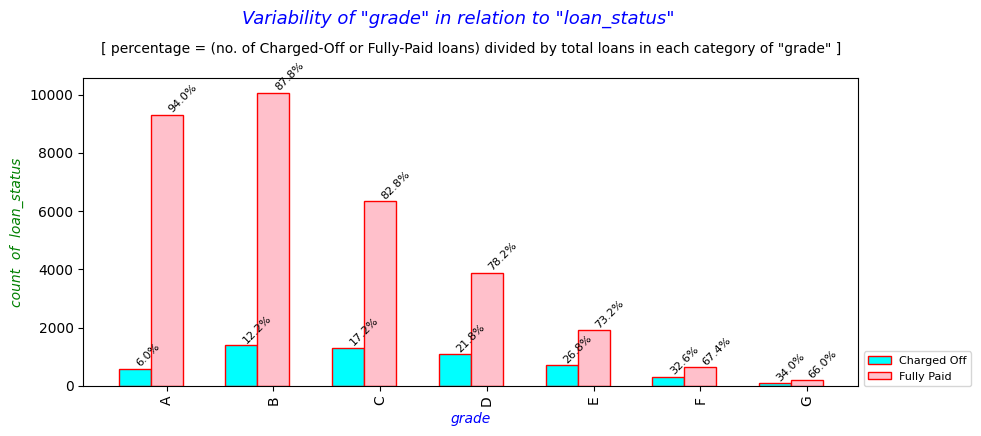

In [29]:
plot_categorical_bivariate(loan_paid_or_default, index_col='loan_status', col='grade', 
                           W=10, H=4, width=.3, bbox_W=1.0, bbox_H=.13, annotate_flag=True,rotate_annotation=45, size=8)

- `Interpretations`
   - Observed that default rate percenage increases from A to G grade. It is evdient that applicants with lower grade are more defaulting. 

2) <span style='color:green'>**emp_length**</span>

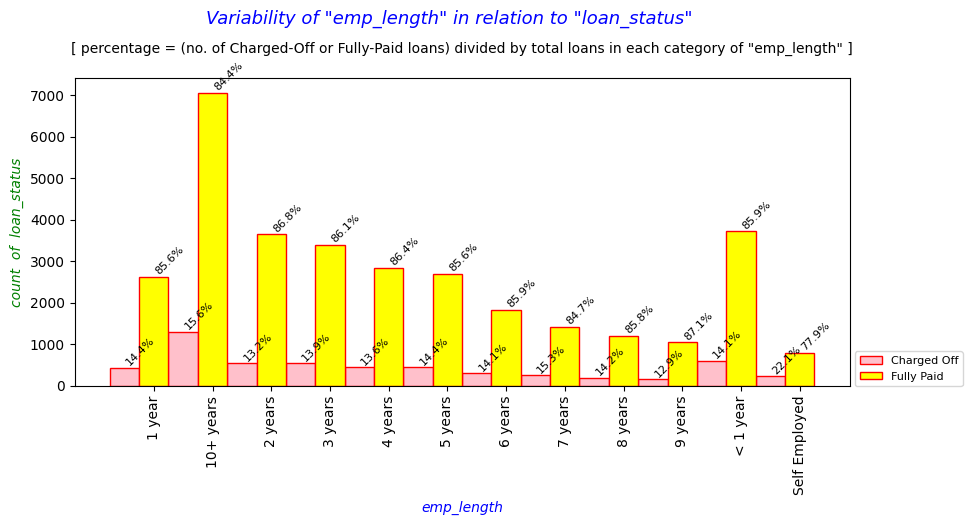

In [30]:
plot_categorical_bivariate(loan_paid_or_default, index_col='loan_status', col='emp_length', 
                           W=10, H=4, width=.5, bbox_W=1.0, bbox_H=.13, annotate_flag=True,rotate_annotation=45, size=8)

- `Interpretations`       
     - The default percentage rate is same across all emp_lenght levels. So this is not a impacting factor for default loans.

3) <span style='color:green'>**home_ownership**</span>

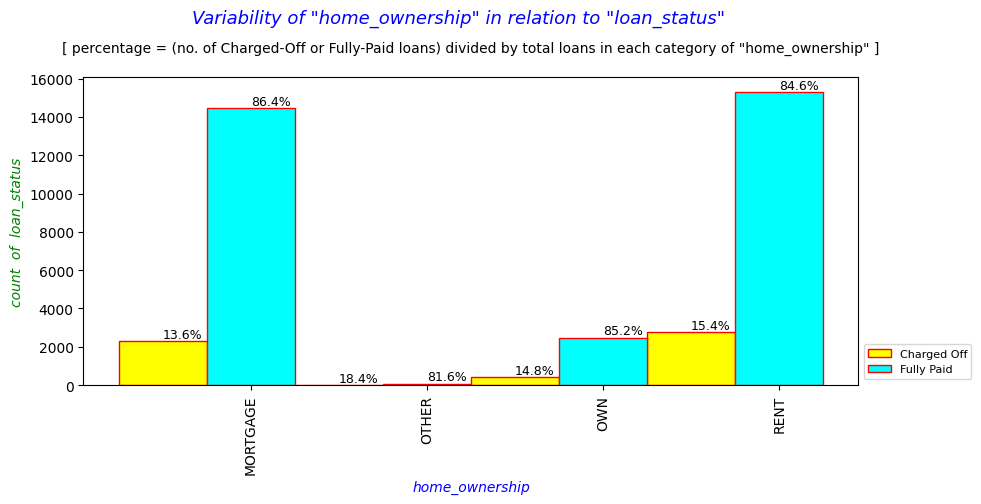

In [31]:
plot_categorical_bivariate(loan_paid_or_default, index_col='loan_status', col='home_ownership', 
                           W=10, H=4, width=.5, bbox_W=1.0, bbox_H=.15,size=9)

- `Interpretations`
       
     - The loan default rate is not varying much across different home ownershtip statues. So this is not impacting factor for default loans. 

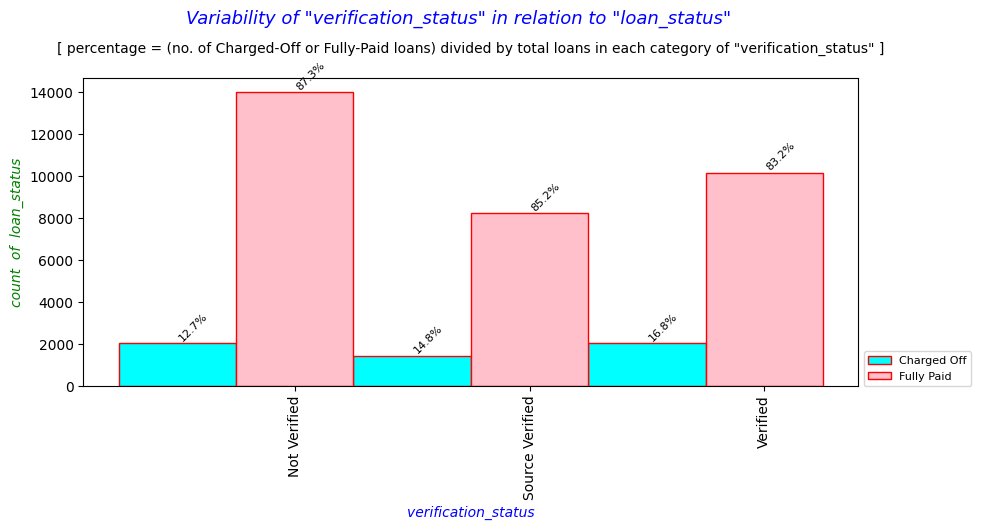

In [32]:
plot_categorical_bivariate(loan_paid_or_default, index_col='loan_status', col='verification_status', 
                           W=10, H=4, width=.5, bbox_W=1.0, bbox_H=.13, annotate_flag=True,rotate_annotation=45, size=8)

- `Interpretations`
       
     - The loan default rate is not varying much across different verification statuses . So this is not impacting factor for default loans. 

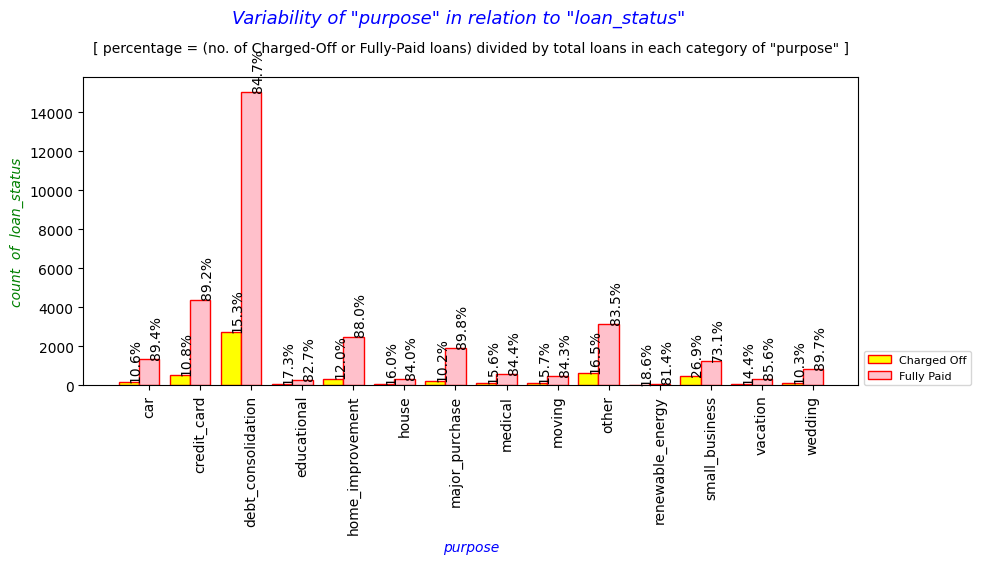

In [33]:
plot_categorical_bivariate(loan_paid_or_default, index_col='loan_status', col='purpose', 
                           W=10, H=4, width=.4, bbox_W=1.0, bbox_H=.13, rotate_annotation=90, size=10)

- `Iterpretation`

  - The percentage of defaulters is higher when their pupose of taking loans is either <span style='color:green'>Debt Consolidation</span>, <span style='color:green'>Educational</span>, <span style='color:green'>House</span>, <span style='color:green'>Medical</span>,
  <span style='color:green'>Moving</span>, <span style='color:green'>Other</span>, <span style='color:green'>Renewable Energy</span>, <span style='color:green'>Vacation</span>. <br>The majority of defaults occur when borrowers take <span style='color:red'>Small Business</span> loans, which makes up about <span style='color:green'>27%</span> of all borrowers who take out these kinds of loans.

  - There is a significant difference in the percentage of defaulters depending on the loan purposes, indicating that this variable is a strong indicator of determining whether the applicant would default. 

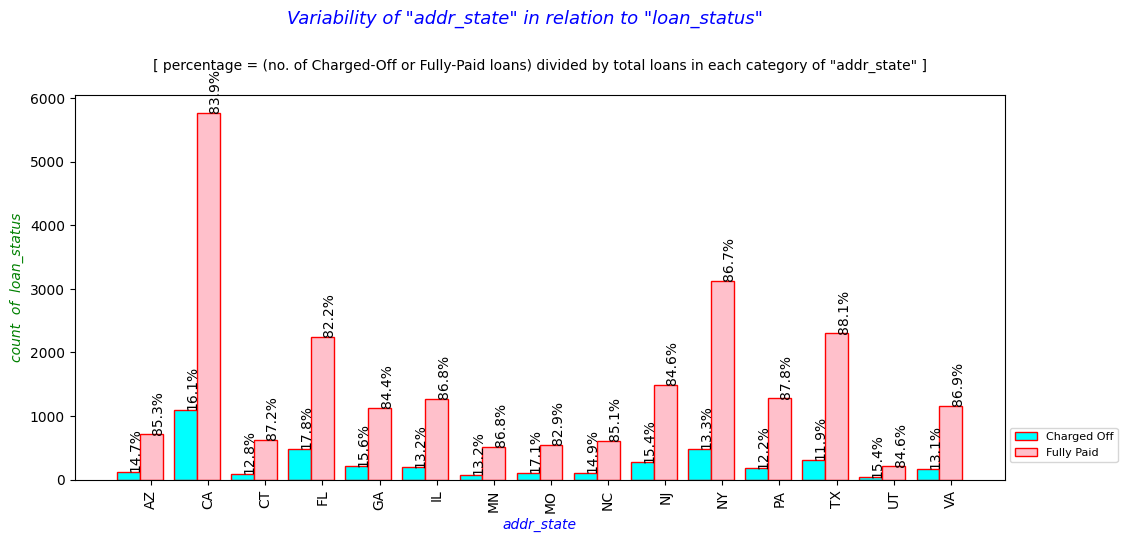

In [34]:
plot_categorical_bivariate(loan_paid_or_default[loan_paid_or_default.addr_state.isin(loan_paid_or_default.addr_state.unique()[:15])], index_col='loan_status', col='addr_state', 
                           W=12, H=5, width=.4, bbox_W=1.0, bbox_H=.15, annotate_flag=True,rotate_annotation=90, size=10)

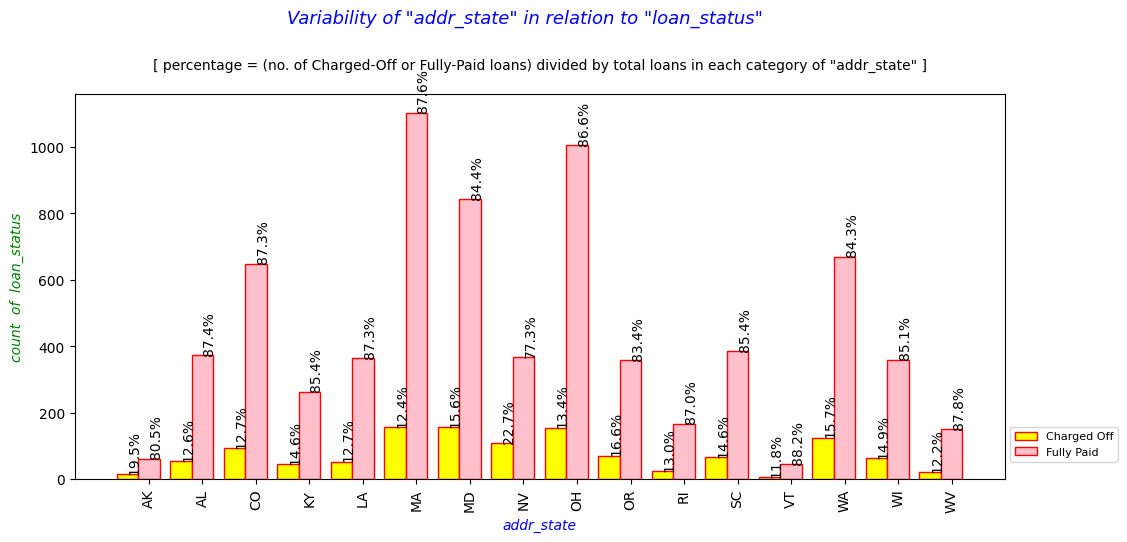

In [35]:
plot_categorical_bivariate(loan_paid_or_default[loan_paid_or_default.addr_state.isin(loan_paid_or_default.addr_state.unique()[15:31])], index_col='loan_status', col='addr_state', 
                           W=12, H=5, width=.4, bbox_W=1.0, bbox_H=.15, annotate_flag=True,rotate_annotation=90, size=10)

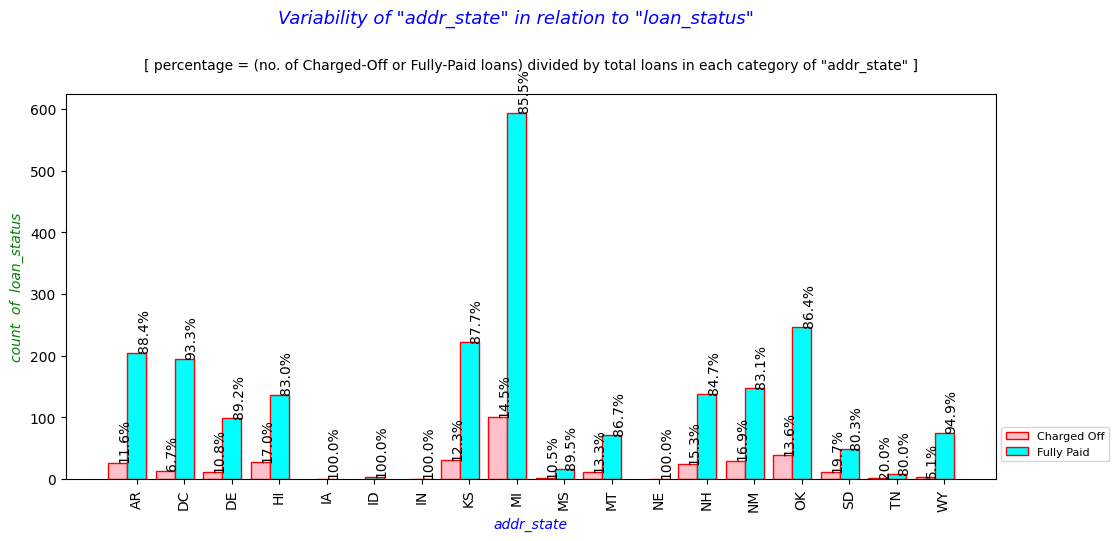

In [36]:
plot_categorical_bivariate(loan_paid_or_default[loan_paid_or_default.addr_state.isin(loan_paid_or_default.addr_state.unique()[31:])], index_col='loan_status', col='addr_state', 
                           W=12, H=5, width=.4, bbox_W=1.0, bbox_H=.15, annotate_flag=True,rotate_annotation=90, size=10)

- `Interpretation from the above plots`


  - Most of the borrowers are from the state California, followed by New York, Florida and Texas states.

### Multivariate Analysis 

**Converting objects to numerical columns**

In [37]:
# Apply the label encoding all grade column

df = loan_paid_or_default

# Label encoding on grade column
from sklearn import preprocessing
def convert_category_to_numerical(df,col):
    le = preprocessing.LabelEncoder()
    le.fit(df[col])
    le.classes_
    print(le.classes_)
    df[col] = le.transform(df[col])
    return df


In [38]:
df = convert_category_to_numerical(df,col="grade")


['A' 'B' 'C' 'D' 'E' 'F' 'G']


In [39]:

df = convert_category_to_numerical(df,col="emp_length")

['1 year' '10+ years' '2 years' '3 years' '4 years' '5 years' '6 years'
 '7 years' '8 years' '9 years' '< 1 year' 'Self Employed']


In [40]:
# One hot encoding on categorical columns
df = pd.get_dummies(df,columns = ['home_ownership','verification_status','purpose','emp_length','loan_status'],drop_first = True)

In [43]:
df.drop(['issue_d','sub_grade','addr_state','id',"annual_inc"],axis =1,inplace=True)

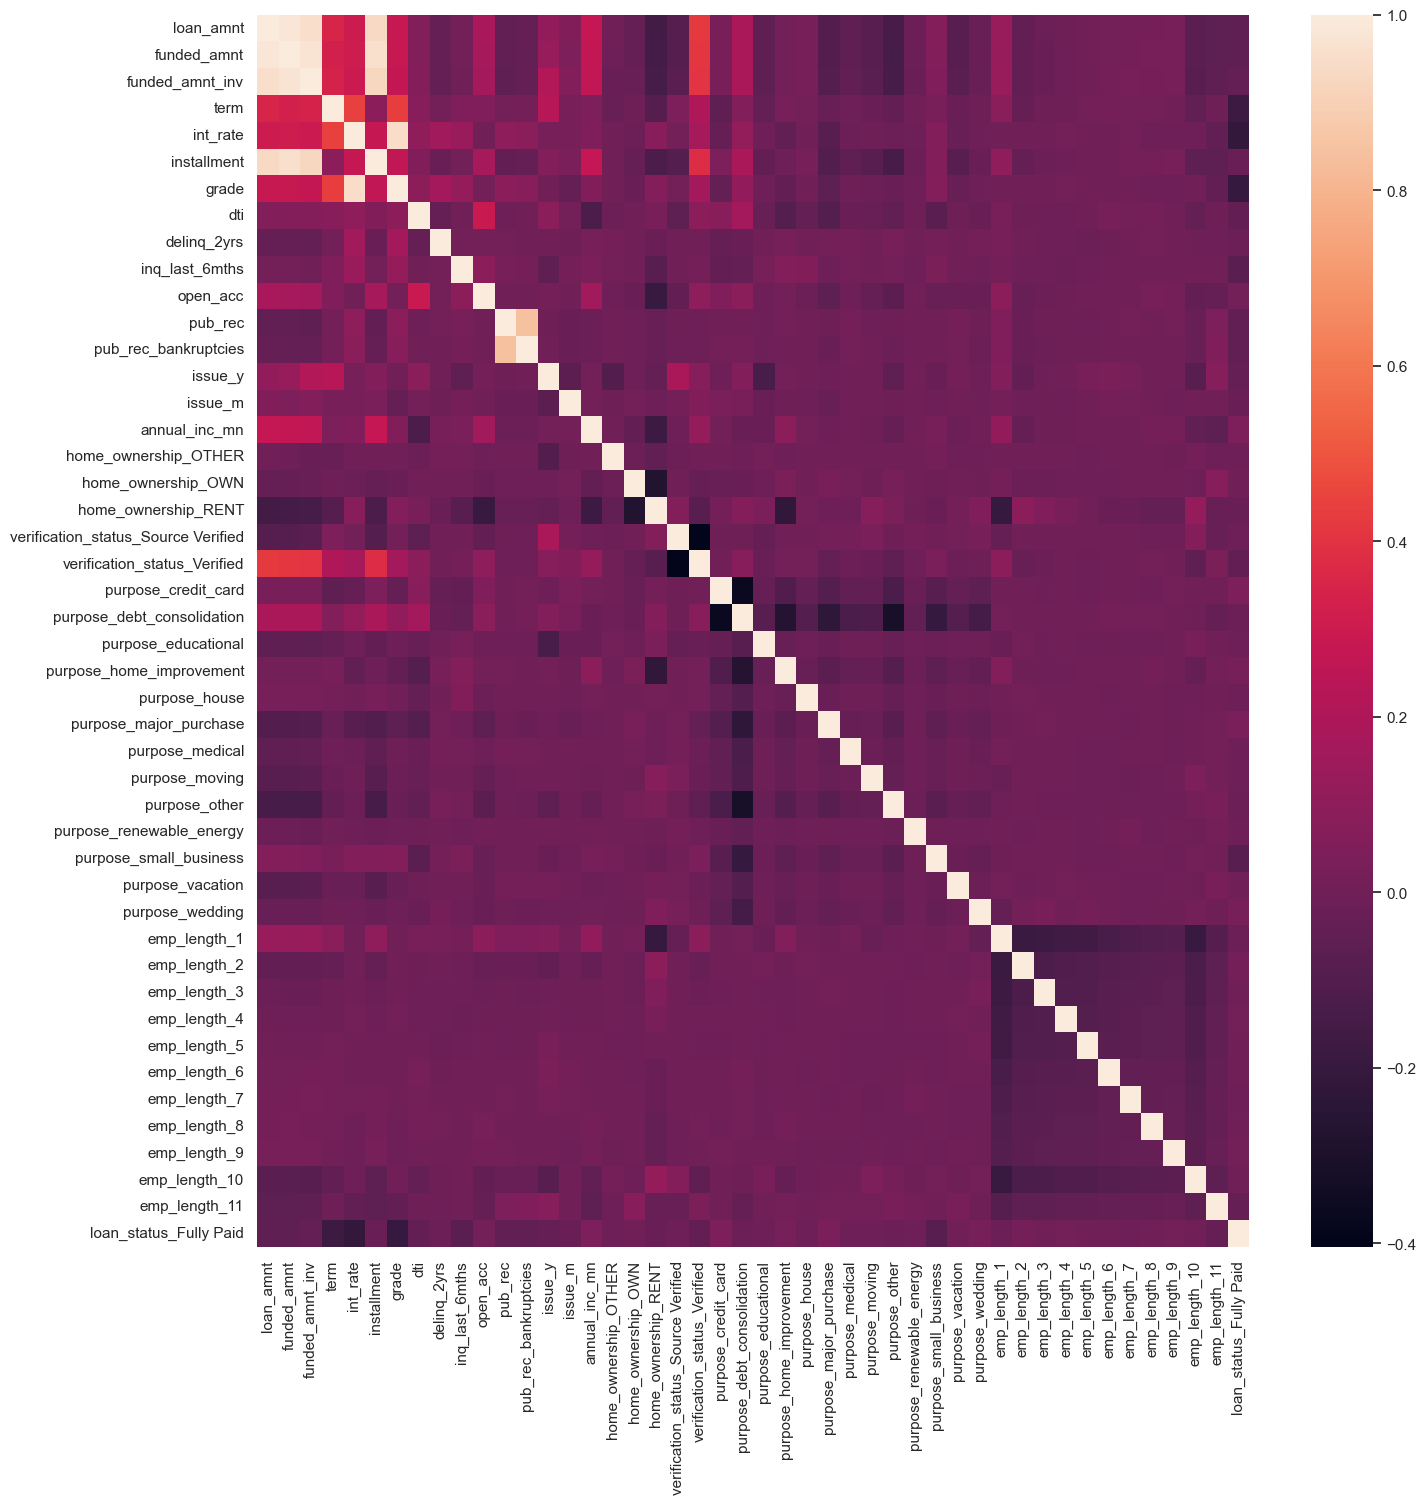

In [44]:
sns.set(rc={'figure.figsize':(16,16)})
#sns.set_style('whitegrid')
# Heatmap
sns.heatmap(df.corr(),fmt='.2g')
plt.show()


<Axes: >

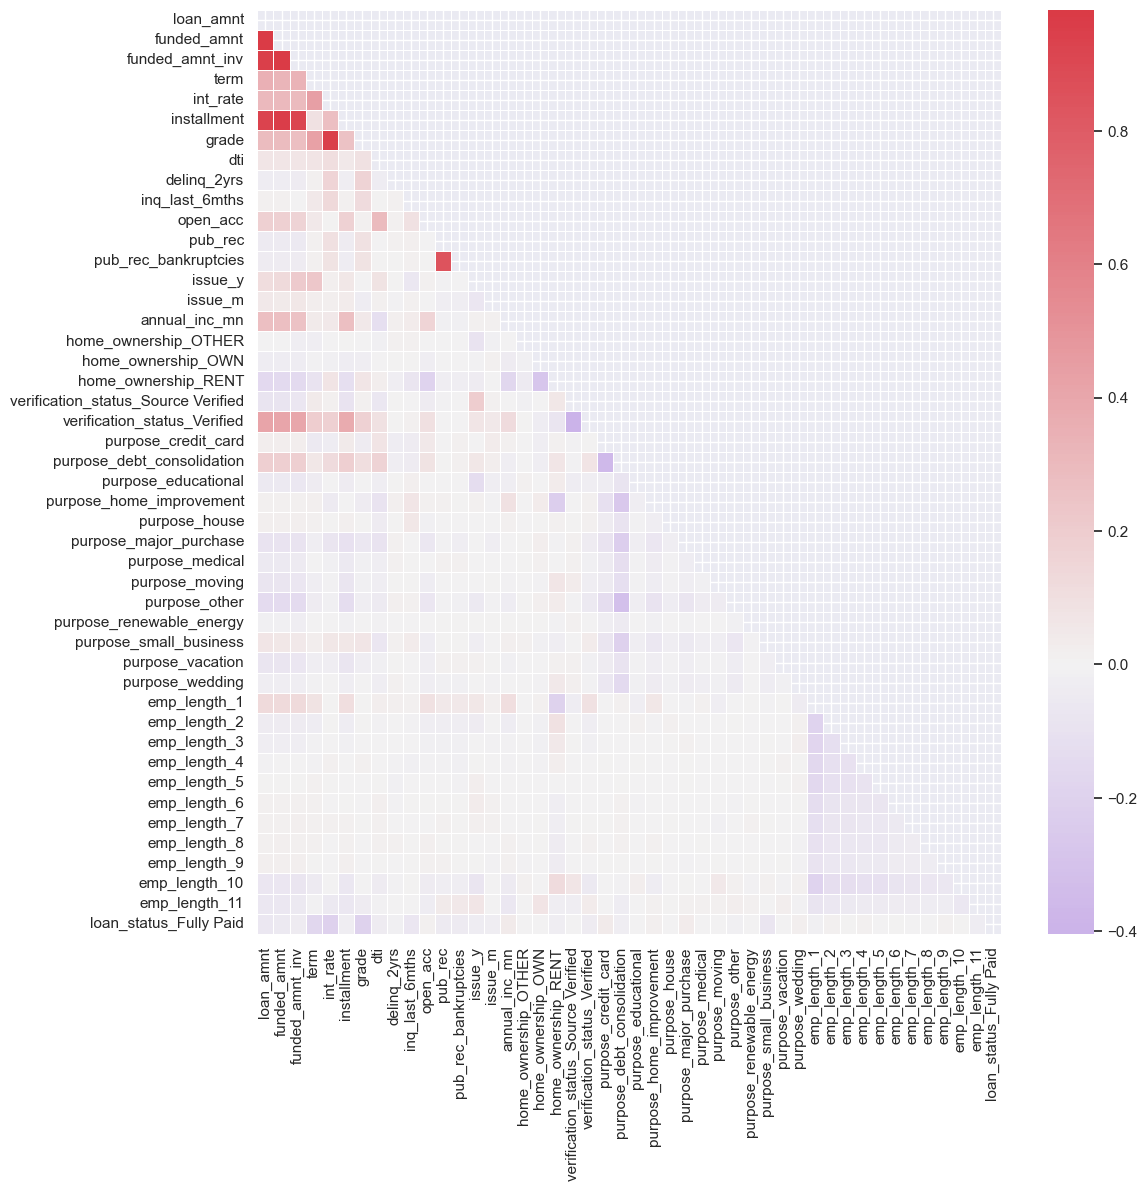

In [45]:
corr = df.corr(method='pearson')
plt.figure(figsize=(12, 12))
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(280, 10,n=200, as_cmap=True)
# Plotting the heatmap
sns.heatmap(corr, mask=mask, linewidths=0.5, cmap=cmap, center=0)

### Interpretation from the above matrix`
  
   - we can conclude that **int_rate** is **highly correlated** to **grade** of the borrowers. 
      **installment** and **funded_amnt_inv**,**loan_amnt**, are highly correlated variables.